# Desafío clasificación texto
_Una empresa de marketing nos ha contratado para clasificar comentarios extraídos de diversas redes sociales. La empresa desea mejorar su capacidad de análisis de sentimientos. Actualmente, los comentarios se clasifican manualmente, lo que es un proceso lento y propenso a errores. La empresa desea implementar un modelo capaz de procesar grandes cantidades de comentarios en tiempo real y clasificarlos automáticamente, sin embargo, necesitan que este sea rápido, por lo que se nos ha pedido que no construyamos modelos basados en redes neuronales._

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting default settings for better images
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['figure.dpi']= 300

from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /Users/Ros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Ros/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1 Parte
### 1 Construir un modelo que sea capaz de clasificar las distintas emociones. El modelo queda a criterio de la/el Data Scientist.
Este es un problema de _sentiment analysis_, que es un problema que cae en el area de _Natural Language Processing_ (NLP). El NLP es la rama de Machine Learning que se ocupa de extraer información y entender el lenguaje humano. El término _sentiment analysis_ se refiere al análisis de la actitud de un sujeto respecto a algo a partir de un texto.

Como veremos este es un _multi-label classification problem_, es decir, un problema de clasificación en el que cada muestra puede pertenecer a más de una de las categorías (_label_). Esto se puede entender como predecir propriedades de la muestra que no son mutuamente exclusivas: en nuestro caso un texto puede expresar multiples emociones al mismo tiempo.

#### 1.1 Exploratory data analysis
Vamos a leer los archivos de este trabajo y ver qué tipo de información traen.

In [55]:
df = pd.read_csv('./data/text_classification_train.csv')
emotions = pd.read_csv('./data/emotions.txt',header=None, names=['emotions'])
test_df = pd.read_csv('./data/text_classification_test.csv')

In [56]:
print(test_df.shape)
test_df.head()

(5427, 2)


text       id
0  I’m really sorry about your situation :( Altho...  eecwqtt
1    It's wonderful because it's awful. At not with.  ed5f85d
2  Kings fan here, good luck to you guys! Will be...  een27c3
3  I didn't know that, thank you for teaching me ...  eelgwd1
4  They got bored from haunting earth for thousan...  eem5uti

In [80]:
print(emotions.shape[0])
emotions.head()

28


emotions
0  admiration
1   amusement
2       anger
3   annoyance
4    approval

In [4]:
df.head()

text emotion       id
0  My favourite food is anything I didn't have to...      27  eebbqej
1  Now if he does off himself, everyone will thin...      27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING       2  eezlygj
3                        To make her feel threatened      14  ed7ypvh
4                             Dirty Southern Wankers       3  ed0bdzj

In [5]:
df.shape

(43410, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     43410 non-null  object
 1   emotion  43410 non-null  object
 2   id       43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


In [7]:
df.describe()

text emotion       id
count        43410   43410    43410
unique       43226     711    43410
top     Thank you.      27  eebbqej
freq            13   12823        1

Tenemos 3 archivos/tablas:
- **emotions**: contiene los 28 nombres de las emociones de este análisis
- **test_df**: contiene ~5000 comentarios que son nuestra muestra de test y los ID de estos.
- **df**: la tabla principal de esta tarea. Contiene ~40000 comentarios que son la muestra de train y validation, los ID de estos y las emociones que estos expresan, codificadas de manera numérica.

##### 1.1.1 Text length
Vamos a ver el largo de los comentarios que vamos a estudiar.

In [103]:
text_len = df.text.str.len().sort_values()
print(f"Shortest text {text_len.head(1).values[0]}")
print(f"Longest text {text_len.tail(1).values[0]}")

iqr = text_len.quantile(q=[0.25,0.75]).values

Shortest text 2
Longest text 703


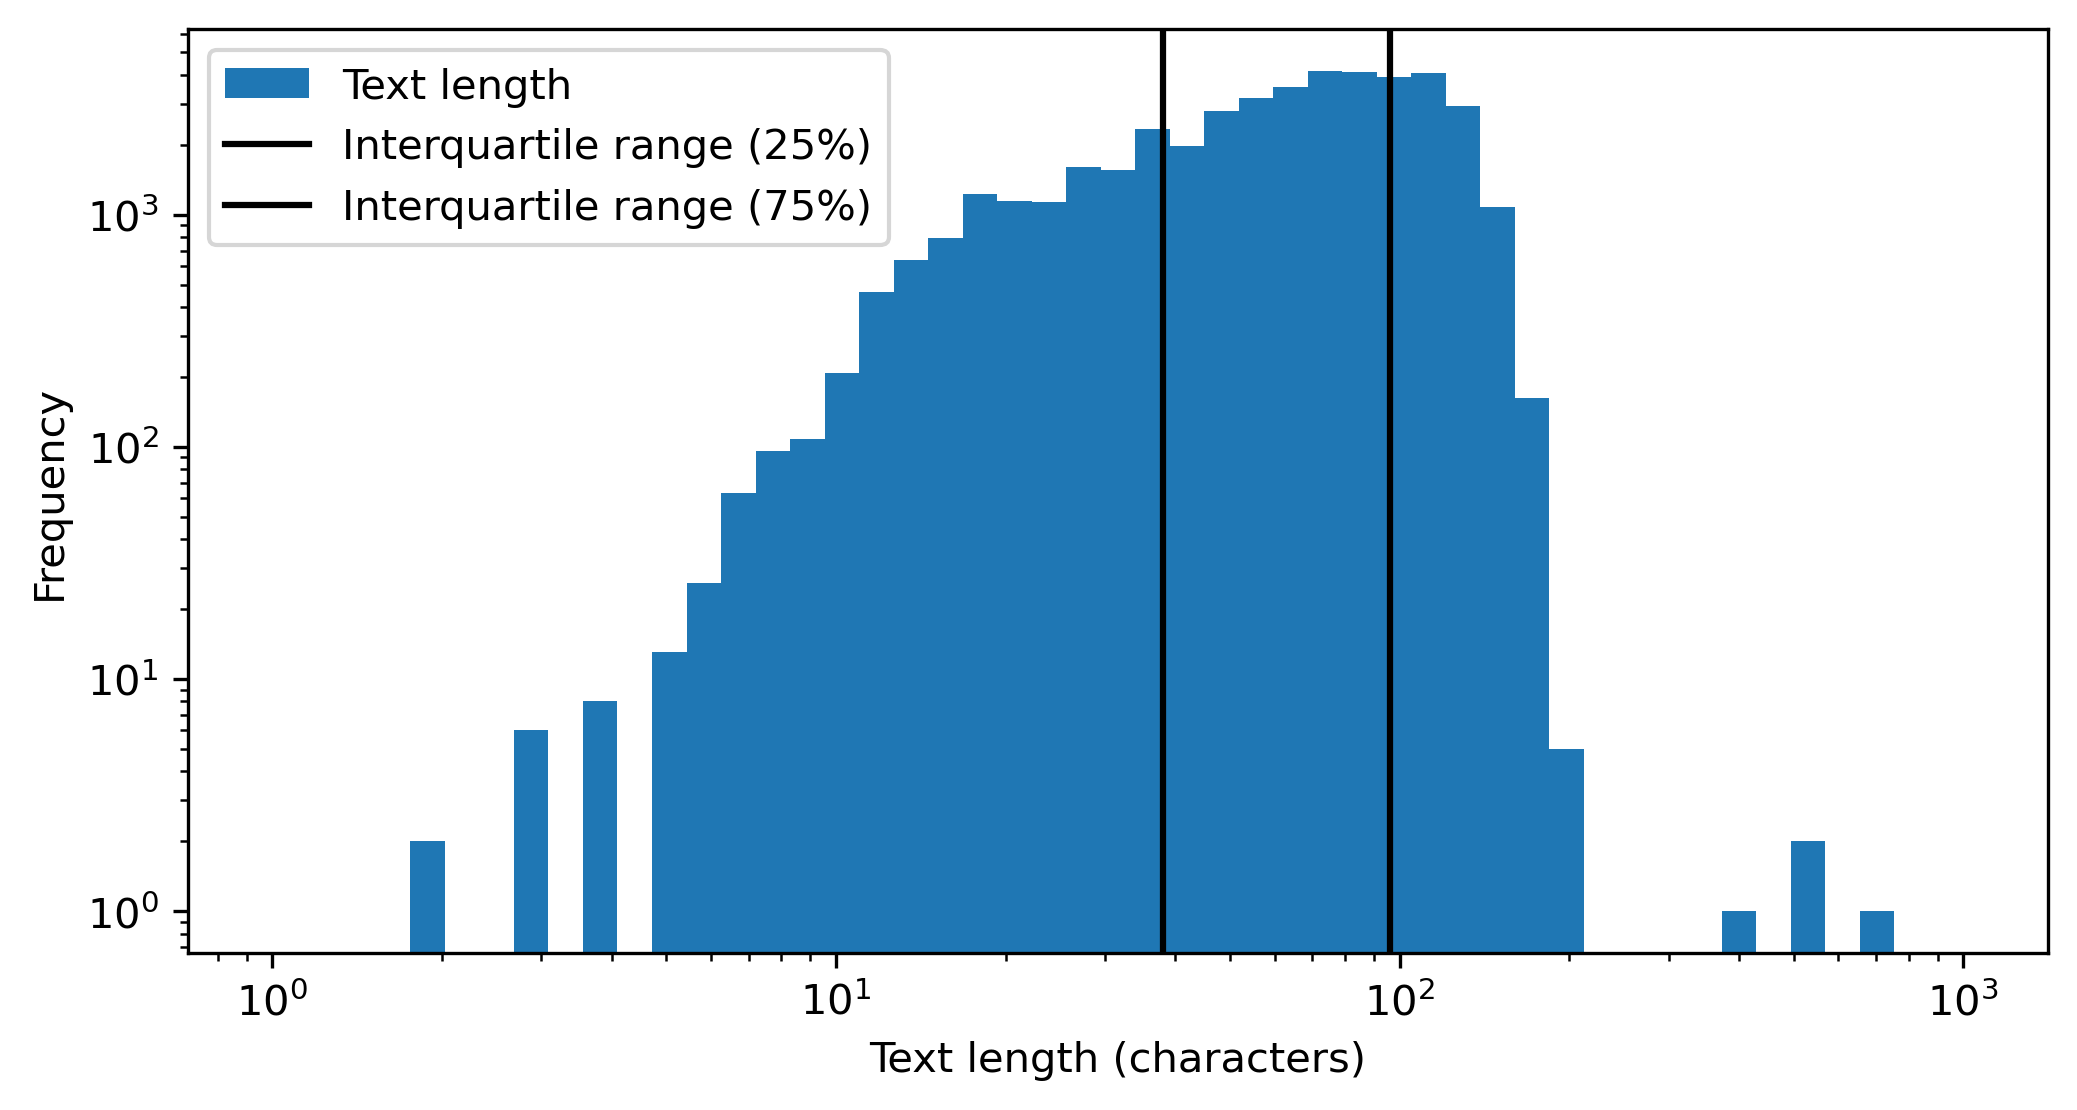

In [106]:
ax = text_len.plot(kind='hist',bins=np.logspace(np.log10(1),np.log10(10**3), 50),label='Text length')

plt.axvline(iqr[0],color='k', label = 'Interquartile range (25%)')
plt.axvline(iqr[1],color='k', label = 'Interquartile range (75%)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Text length (characters)')
plt.legend()
plt.show()

Nuestro texto más corto contiene solo dos letras, el más largo más de 700. La mayoría de los comentarios tienen entre las decenas y el centenar de letras. Tenemos desde textos muy sencillos a más elaborados.

##### 1.1.2 Language detection
Un examen preliminar sugiere que los comentarios sean todos en inglés. Vamos a averiguar hasta qué punto esto es cierto usando un package que hace exactamente esto.

In [108]:
def my_detect_langs(text):
   try:
      return detect(text)[:2]
   except:
      return "error"

In [109]:
df['language'] = df.text.apply(my_detect_langs)

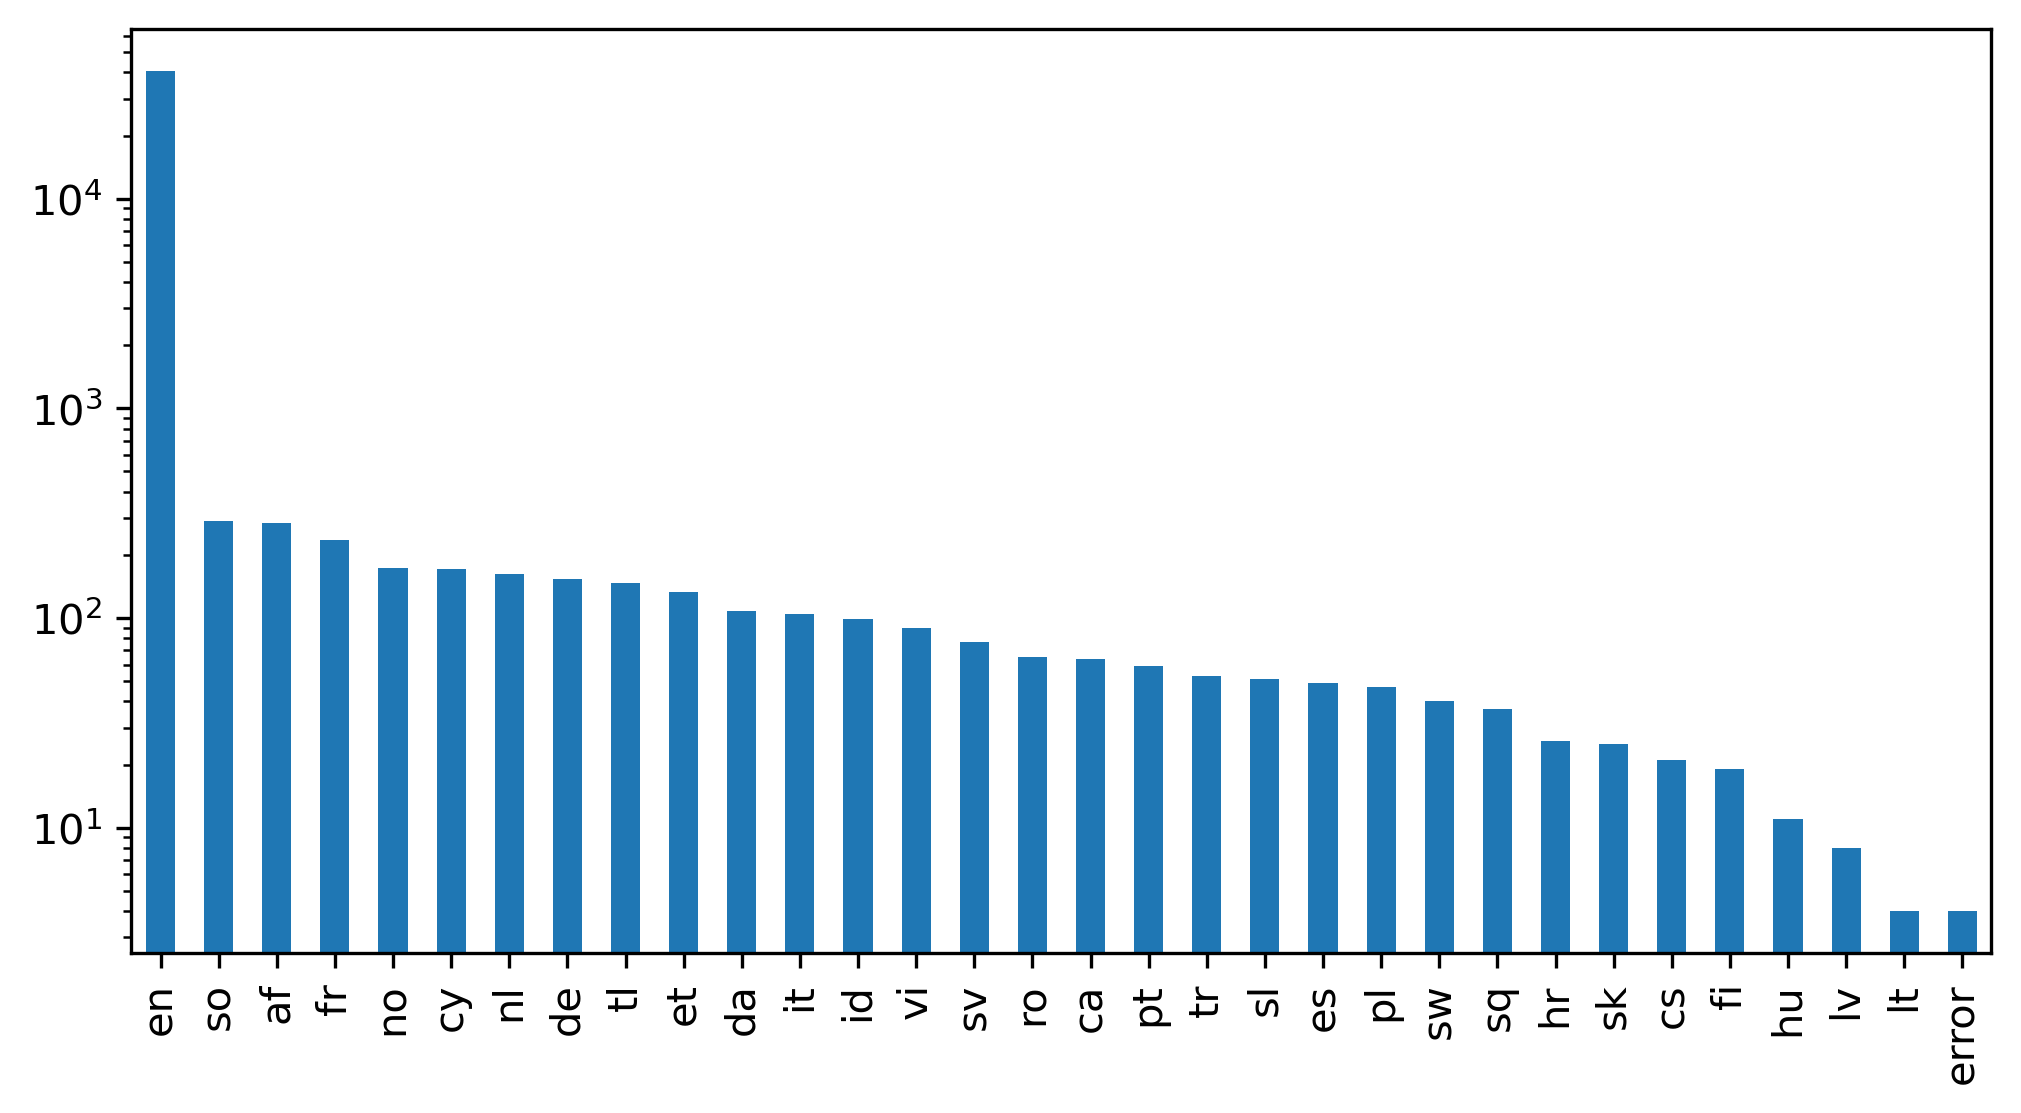

In [12]:
ax = df.language.value_counts().plot(kind='bar')
ax.set_yscale('log')

In [115]:
print(f"Percentage of English comments: {df.language.value_counts()['en']/df.shape[0]*100:.0f}%")

Percentage of English comments: 93%


Podemos ver que casi todos los comentarios son clasificados como idioma inglés. Tenemos un percentaje muy bajo (7%) de comentiarios en otros idiomas y algunos que no se han logrado clasificar. No sabemos con qué exactitud se han podido determinar los idiomas, el algoritmo se puede haber confundido a causa de alguna abreviación, o de un texto demasiado corto. Por esta razón no vamos a excluir a ningún comentario del análisis.

Repetimos la detección de idiomas en la muestra de test y vemos que esta muestra es parecida:

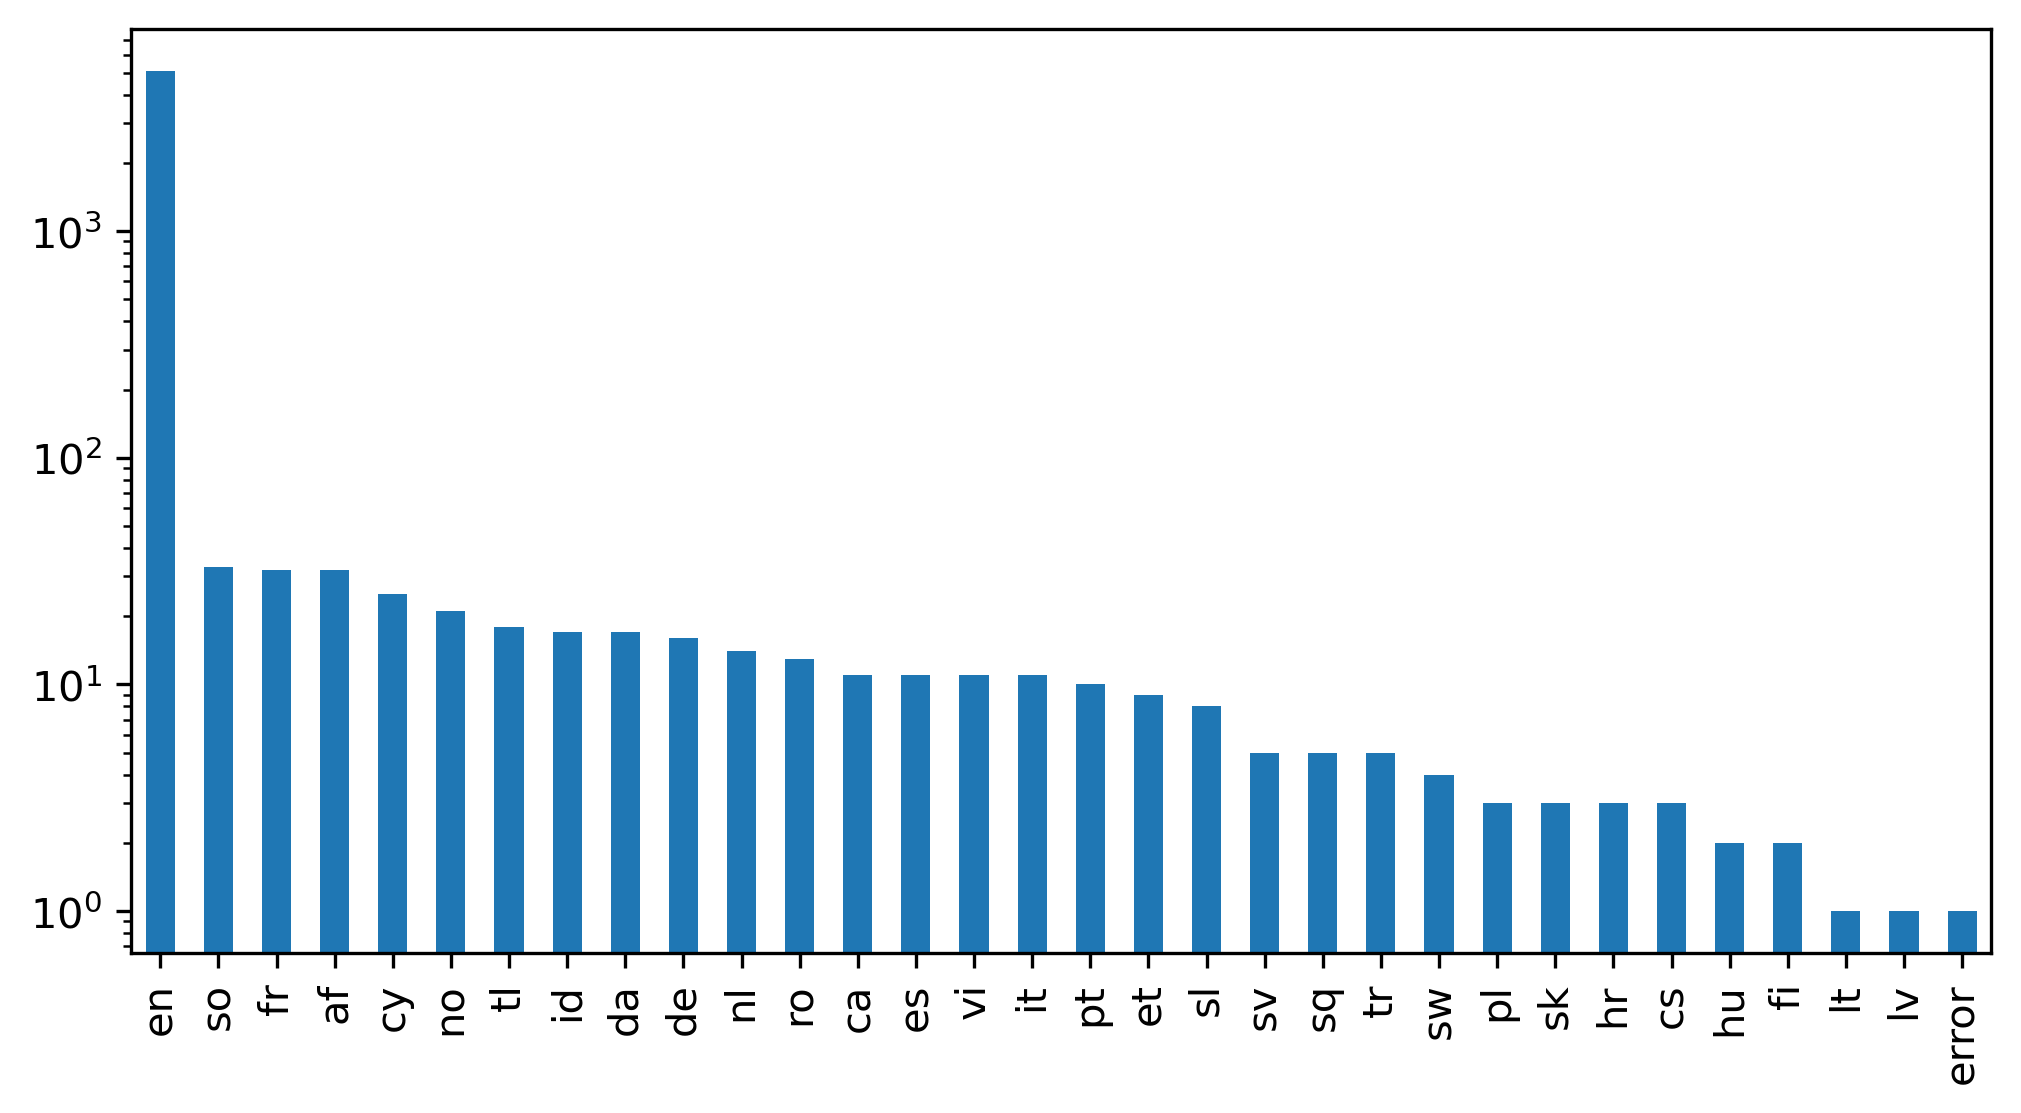

Percentage of English comments: 94%


In [121]:
test_language = test_df.text.apply(my_detect_langs)
ax = test_language.value_counts().plot(kind='bar')
ax.set_yscale('log')
plt.show()

print(f"Percentage of English comments: {test_language.value_counts()['en']/test_df.shape[0]*100:.0f}%")

##### 1.1.3 Word Cloud
Vamos a hacer un _word cloud_ con el texto de los comentarios. Esto nos va a dar una impresión de conjunto del texto que nos enfrentamos.

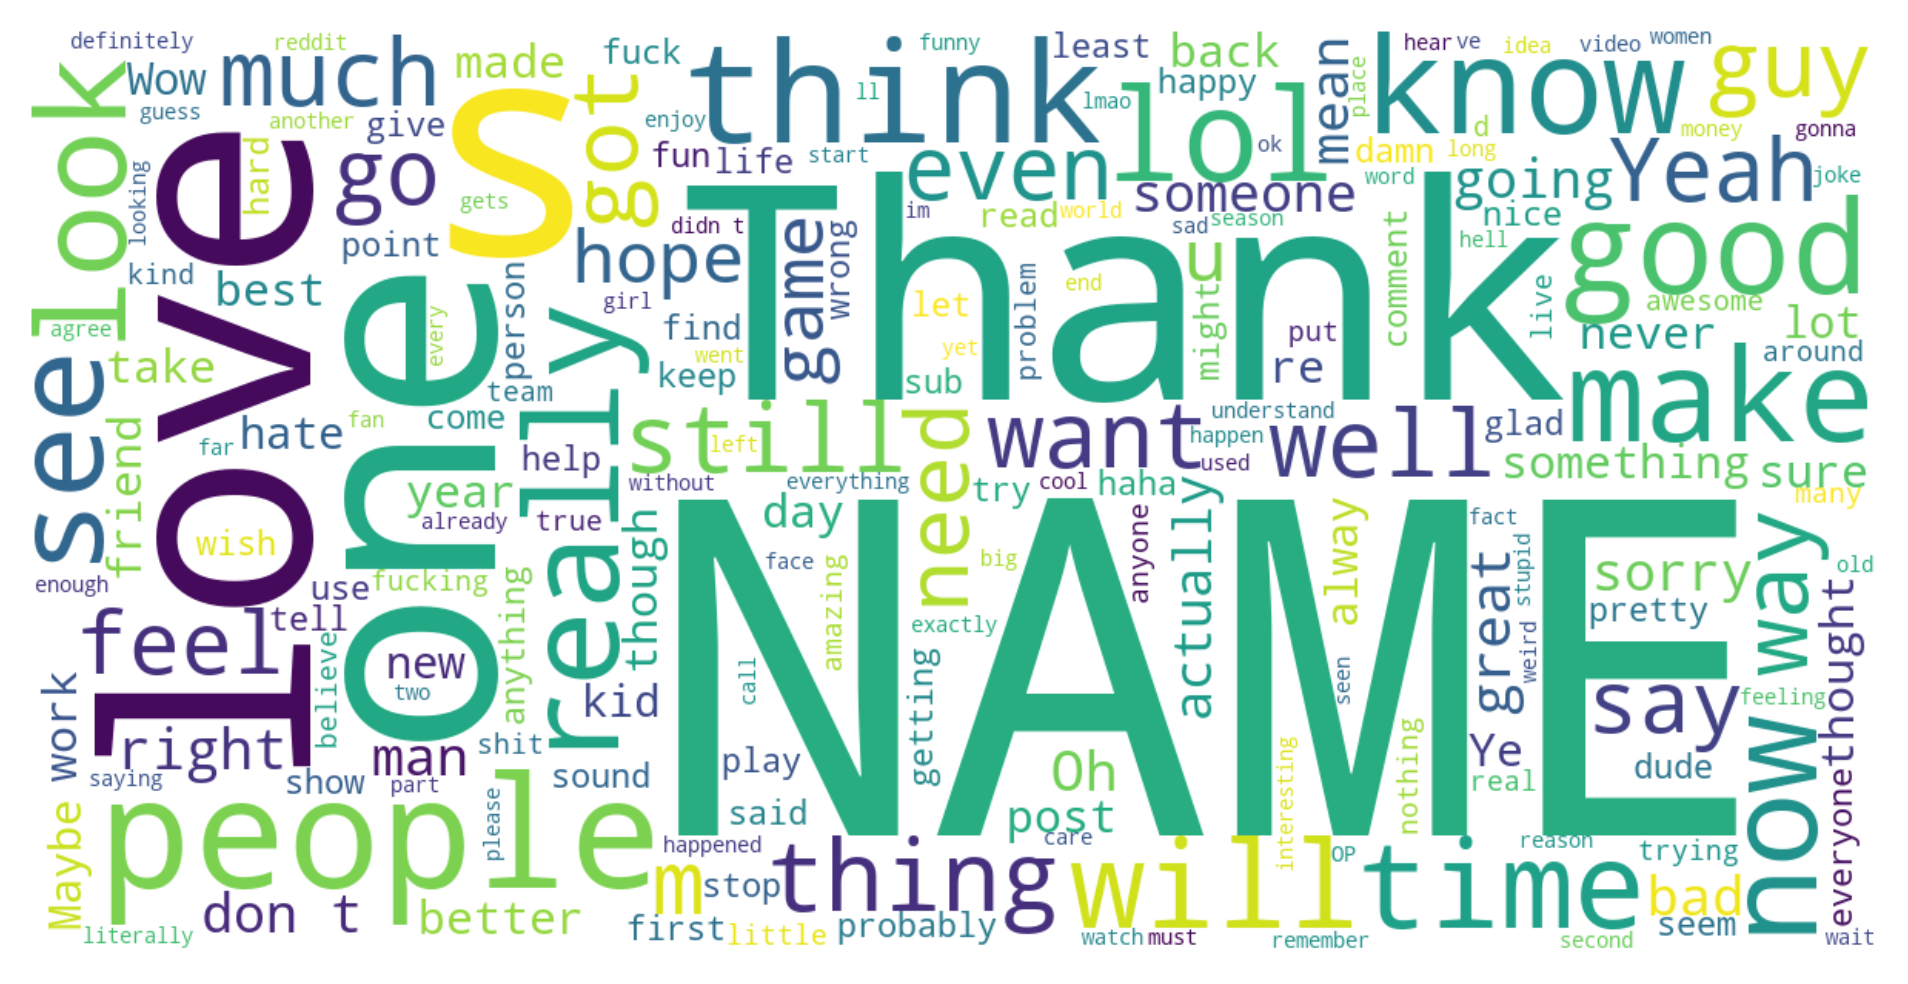

In [9]:
string_of_text = ' '.join(df.text)
wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS,width=1200, height=600).generate(string_of_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Notamos que varias palabras con connotación positiva son muy frecuentes: love, thank, good, lol.

No se notan parabras con connotación negativa de gran tamaño.

#### 1.2 Data preparation
Para que los modelos de machine learning puedan entender nuestros datos tenemos que ponerlos en un formato idoneo.
##### 1.2.1 Target variable preprocessing
Nuestra _target variable_ `emotions` viene en formato numérico, por lo que esto nos economiza un step de preparación. Lo siguiente que es necesario, ya que tenemos un multi-label problem, es convertir las emotions a un formato dummy, donde tenemos una columna para cada emoción (representada como número) y valores binarios para representar si esta es o no parte de la clasificación.

In [4]:
emotions_tmp = df.emotion.str.split(',').apply(pd.Series).astype(float)

# Get dummy variables
emotion_dummies = pd.get_dummies(emotions_tmp.stack()).groupby(level=0).sum()

In [5]:
original_categories = [f'{int(col)}' for col in emotion_dummies.columns]
emotion_dummies.columns = original_categories
emotion_dummies

0  1  2  3  4  5  6  7  8  9  ...  18  19  20  21  22  23  24  25  26  \
0      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
1      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
2      0  0  1  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
3      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
4      0  0  0  1  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
...   .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
43405  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   0   
43406  0  0  0  0  0  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   0   
43407  0  0  0  1  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
43408  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   
43409  0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   0   

       27  
0       1  
1       1  
2       0  
3       0  
4       0  
...    ..  
43405   0  
43406   0  
43407   0  
43408   0  
43409   0  

[43410 rows x 28 columns]

Vamos a preparar una función que invierta esta transformación para cuando vayamos a guardar las predicciones de nuestra muestra de test:

In [65]:
def inverse_dummy(emotion_dummies):
   original_categories = emotion_dummies.apply(lambda x: emotion_dummies.columns[x == 1].tolist(), axis=1)

   # Convert the list of categories to a comma-separated string
   original_categories_str = original_categories.apply(lambda x: ','.join(map(str, x)))

   # Convert the comma-separated string back to a pandas Series
   Y_inv = pd.Series(original_categories_str)

   #np.sum(y_inv == df.emotion)/y_inv.shape[0]
   return Y_inv

Visualicemos la frecuencia de cada emoción:

In [66]:
def emotions_hist(emotion_dummies_df,title='Emotions frequency'):
   ax = emotion_dummies_df.sum().plot(kind='bar',xlabel='Emotions',ylabel='Frequency')
   plt.xticks(ticks=emotions.index, labels=emotions.emotions)
   ax.set_yscale('log')
   ax.set_title(title)
   return ax

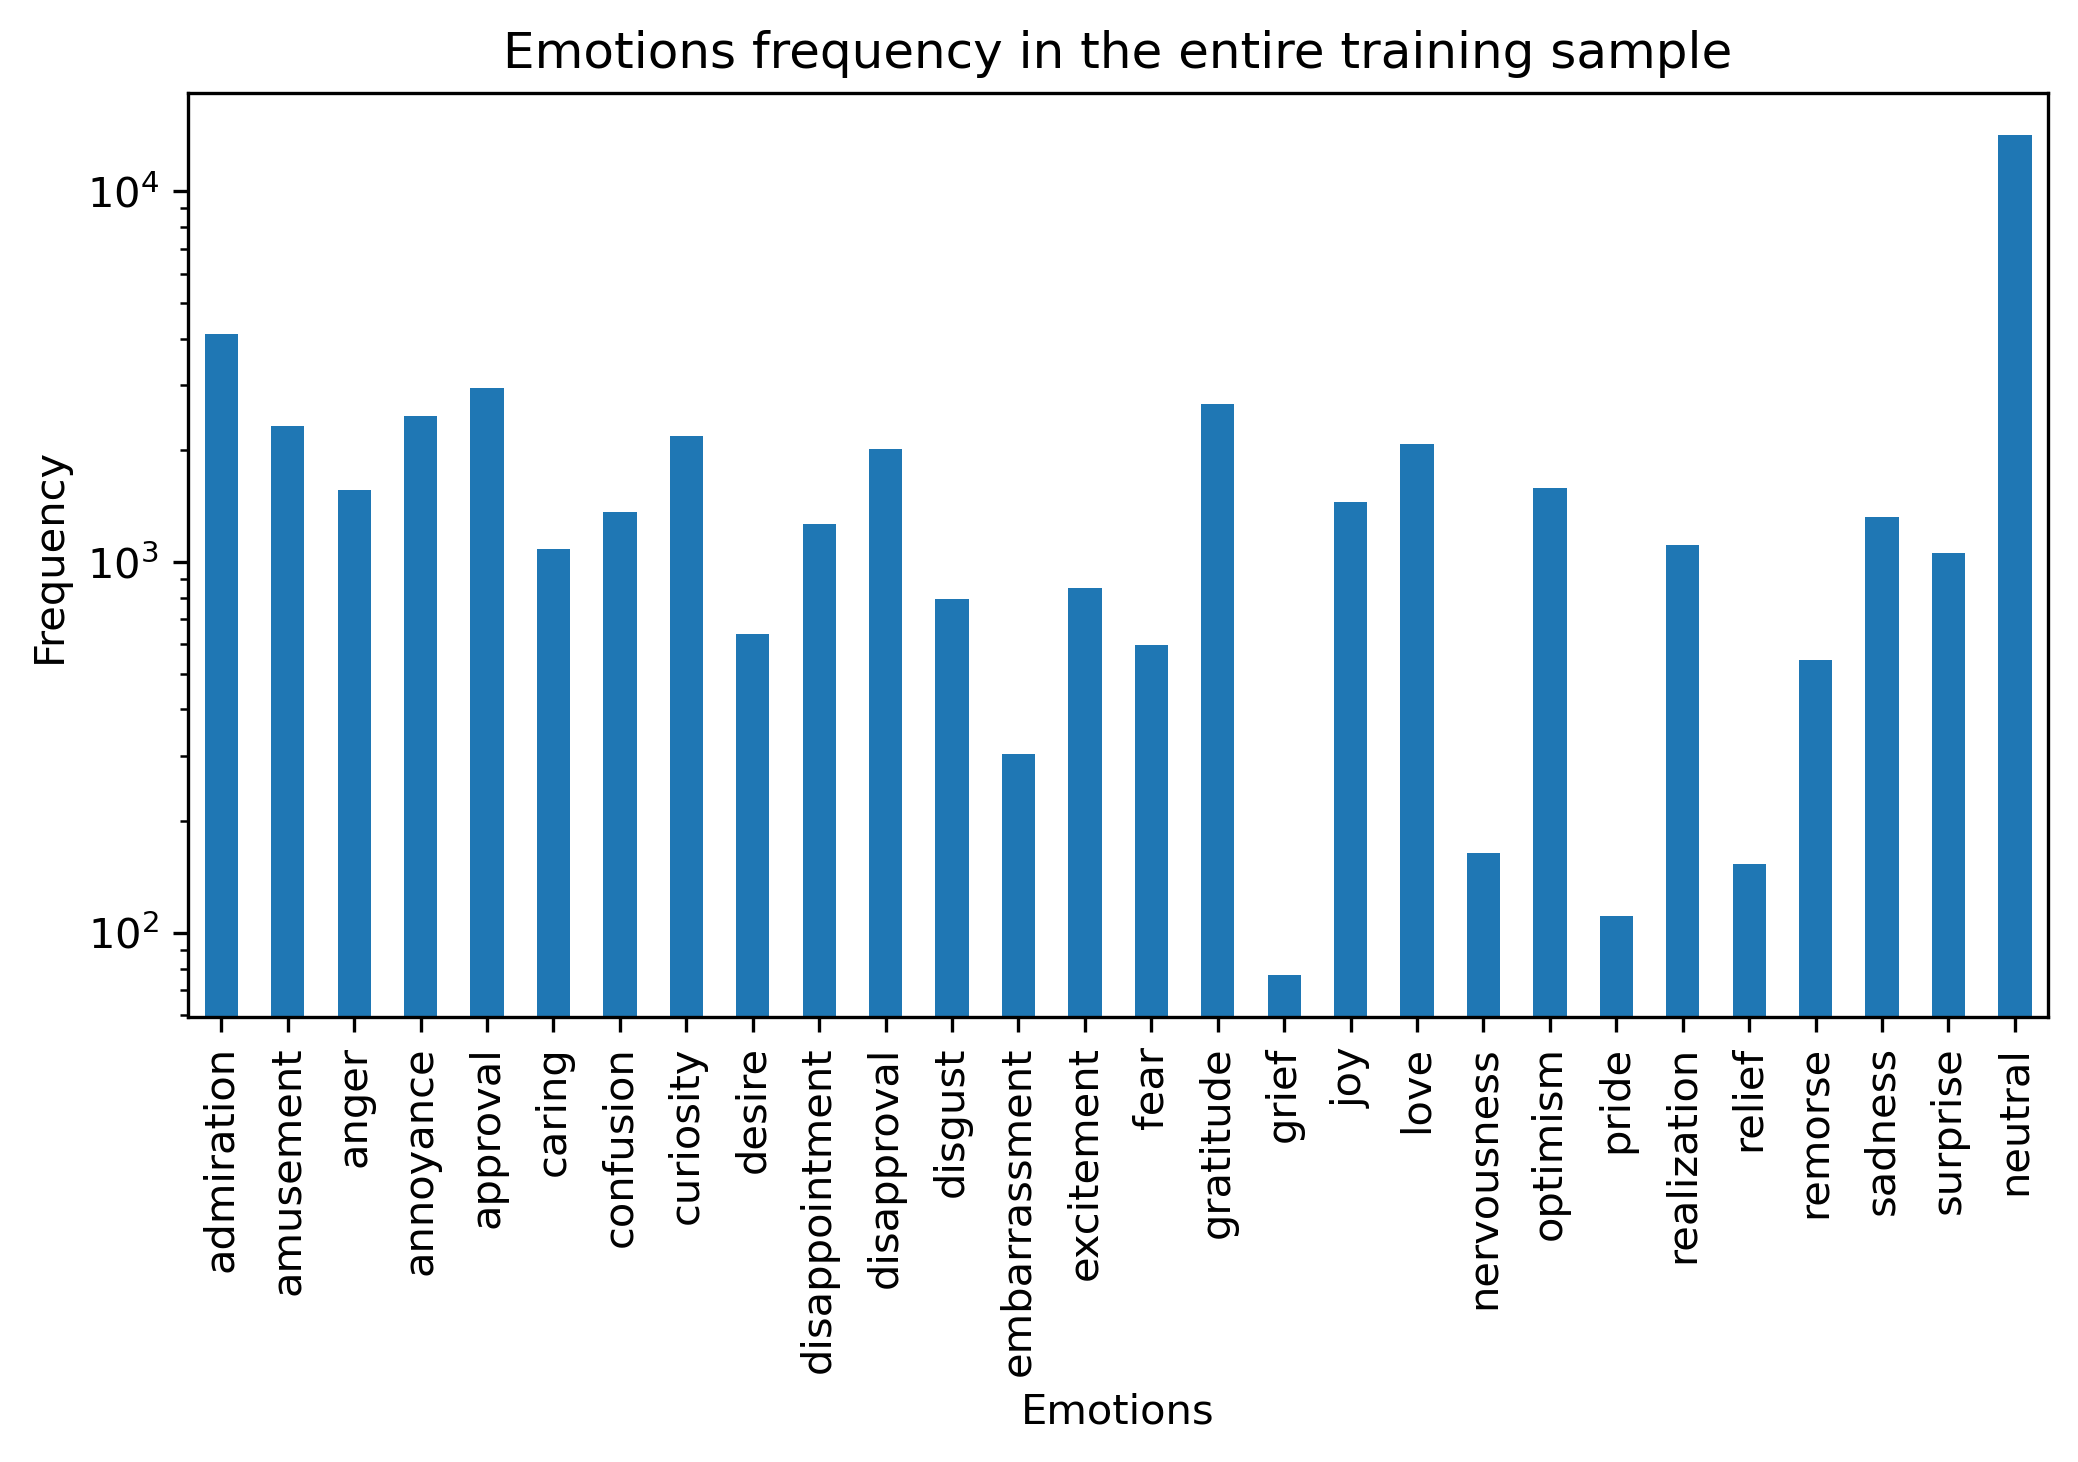

In [67]:
ax = emotions_hist(emotion_dummies,title="Emotions frequency in the entire training sample")
plt.show()

Vemos que la emoción más frecuente en absoluto es _neutral_, que caracteriza más de 10 000 comentarios. Emociones como _pride_, _grief_ y _relief_ tienen representación muy pequeña (~100 comentarios, 0.2% de la muestra), por lo que serà más dificil que el modelo aprenda a reconocerlas.

Esta presencia de muchas emociones y en especial de algunas con muy pocas muestras será la primera limitación de cualquier modelo que podamos diseñar.

##### 1.2.2 Word Vectorization
El siguiente paso es convertir el texto que vamos a analizar al formato entendible por la maquina. Este step es la _vectorization_, y consiste en transformar a cada texto en un vector con cuánta más información posible en la dimensión menor posible. 

En este paso también hacemos el data cleaning, es decir removemos palabras que tienen poco significado (stop words, números), o que pueden introducir ruido (símbolos no convencionales, palabras con muy poca frecuencia).

Otra parte importante de este paso es el _stemming_, que es útil para reducir el tamaño del diccionario (es decir, la dimensión geométrica de representación de cada comentario) ya que va a juntar palabras con la misma raiz y con significado parecido, haciendo el análisis más ágil. Una alternativa al _stemming_ es _lemmatization_. Este toma en consideración también el rol en la frase de una palabra y enriquece el análisis, sin embargo, este paso es más _time consuming_ y se nos ha pedido un modelo rápido de ejecutar.

Como tipo de vectorizer hemos elegido el `TfidfVectorizer`, que es una estadística campaz de medir la importancia de una palabra en un documento.

Al final vemos que nuestos comentarios tendrán una dimensión de ~8000 y las palabras respectan nuestros criterios de selección.

In [8]:
# Load NLTK's stop words
stop_words = set(stopwords.words('english'))

# Create a stemmer
stemmer = PorterStemmer()

# Define a tokenizer function
def tokenize(text):
    # Split the text into words
    tokens = nltk.word_tokenize(text)
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Stem the remaining words
    tokens = [stemmer.stem(token) for token in tokens]
    # Filter tokens that do not match the desired pattern
    tokens = [token for token in tokens if re.match(r'\b[^\d\W][^\d\W]+\b', token)]
    return tokens

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2),min_df=5)

# Convert the text data to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df.text)

# Display the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out())
print(tfidf_df.shape)
tfidf_df.columns

/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(43410, 8514)


Index(['aa', 'ab', 'abandon', 'abhorr', 'abil', 'abl', 'abl get', 'abl help',
       'abnorm', 'abort',
       ...
       'yr old', 'yt', 'yuck', 'yum', 'yup', 'zero', 'zion', 'zombi', 'zone',
       'zoom'],
      dtype='object', length=8514)

#### 1.3 Model definition
##### 1.3.1 Train-test-split
Para poder seleccionar un modelo tenemos que tener una muestra de _training_ y una de _validation_ (que por brevedad llamaremos de test, aunque esto se confunda con la muestra que se nos entregó sin labels).

Con la muestra de test podremos averiguar cómo se porta nuestros modelos y qué tan exactos (_accurate_) son. Esto es muy importante para seleccionar los hiperparámetros mejores.

La muestra de test tiene que tener buena representación de cada emoción, por lo que vamos a definir unas funciones diseñadas para esto y luego vamos a averiguar que la frecuencia de las emociones sea igual en las dos muestras.

In [9]:
# from https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py

def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])

def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]

In [10]:
X = tfidf_matrix
Y = emotion_dummies

X_train, X_test, Y_train, Y_test = multilabel_train_test_split(X, Y, size = 0.15, seed=123)

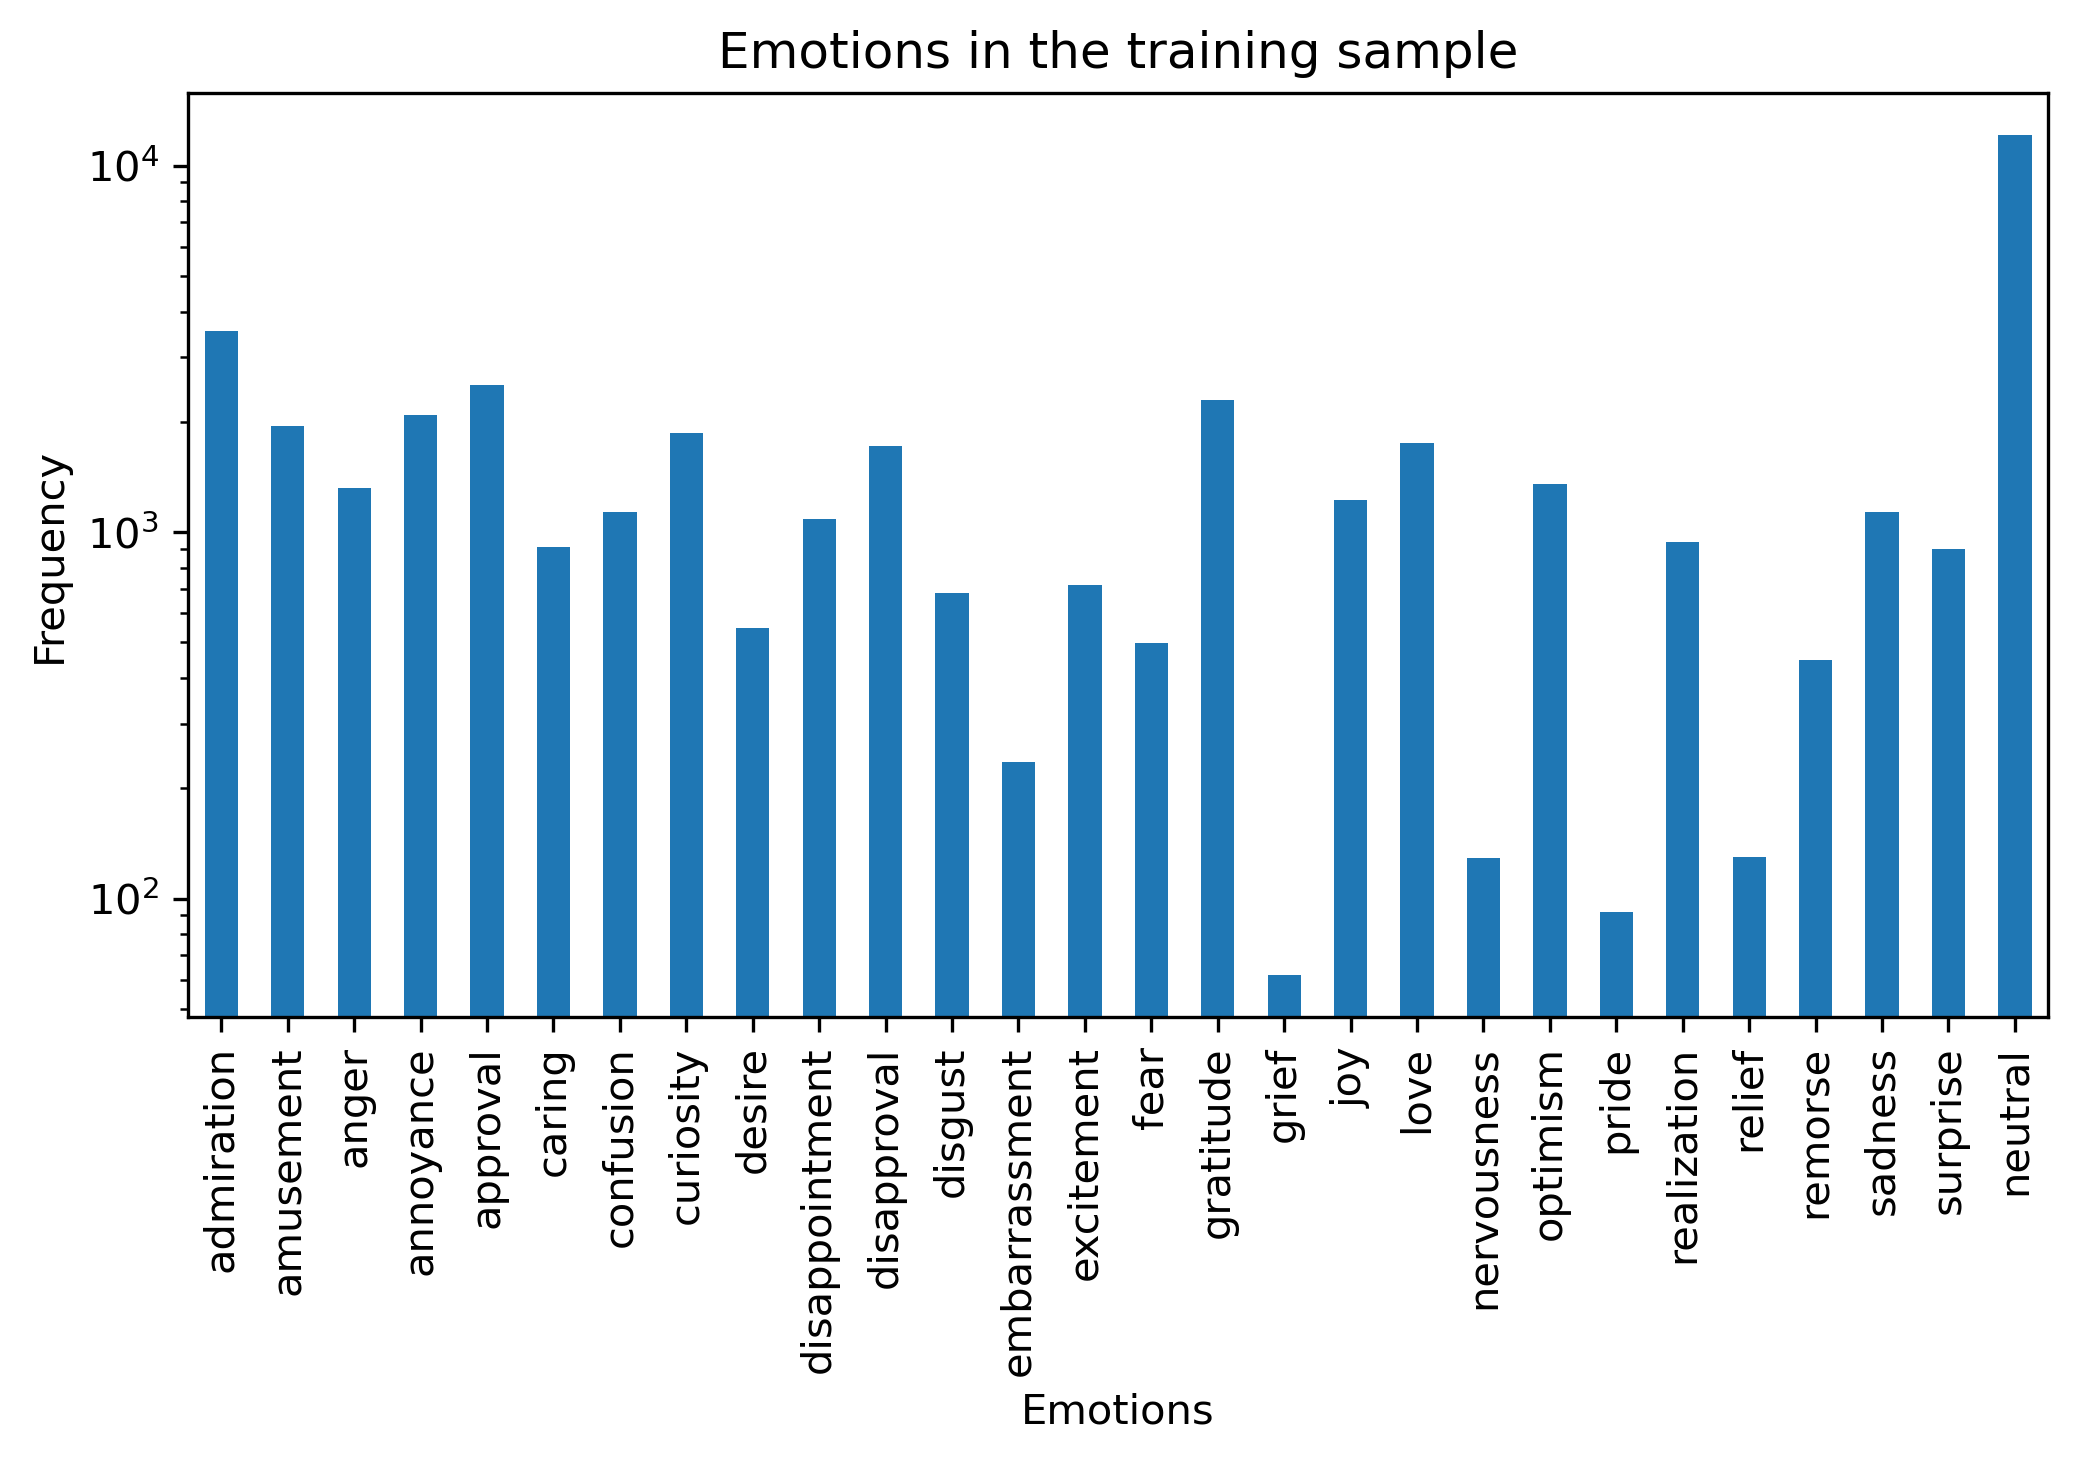

In [70]:
ax = emotions_hist(Y_train,title="Emotions in the training sample")
plt.show()

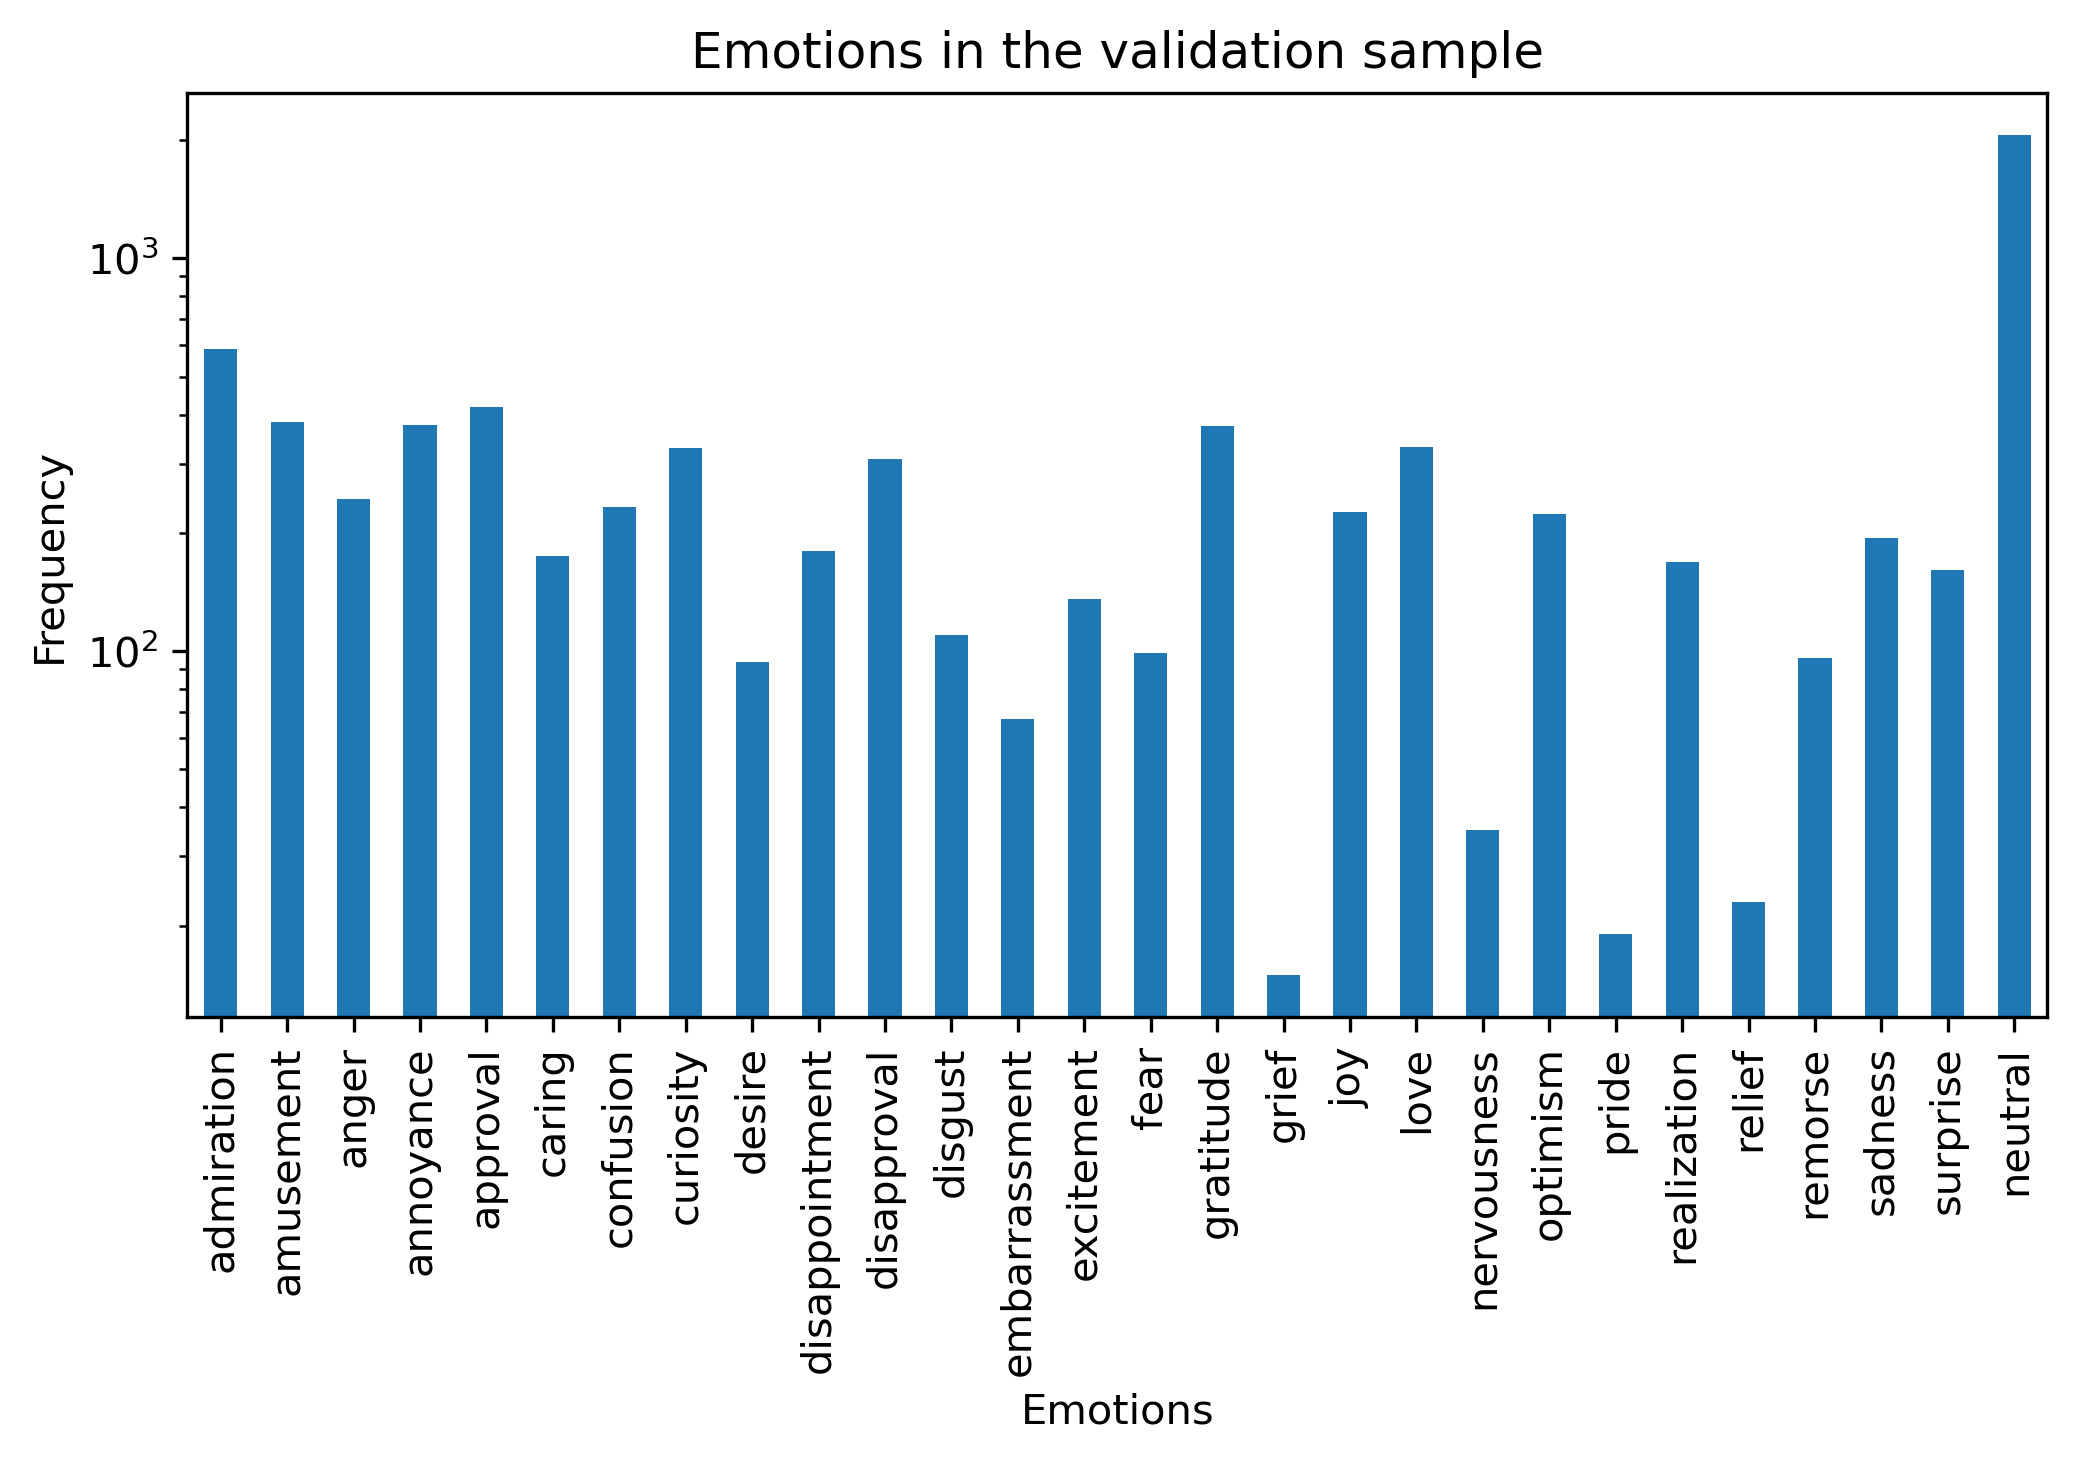

In [71]:
ax = emotions_hist(Y_test,title="Emotions in the validation sample")
plt.show()

##### 1.3.2 Metrics definition
Como tenemos una cantidad muy grande de emociones, cada una de estas será presente en un percentaje bajo de comentarios. Posibles métricas a usar son:

(leyenda: tp - true positives; tn - true negatives; fp - false positives; fn - false negatives. Los _false_ son clasificaciones equivocadas, los _true_ son correctas).

- accuracy
$$accuracy=\frac{tp+tn}{tp+tn+fp+fn}$$
Esta métrica está muy desbalanceada por los negatives, que son la mayoría en nuestra muestra.


- precision (positive predicted value):
$$PPV=\frac{tp}{tp+fp}$$
Una alta precisión significa que el clasificador tuvo una baja _false positive rate_, predicciones de emociones que estàn equivocadas. En nuestro caso esta métrica tendrá un peso mayor hacia los false positives, ya que los true negatives, que pueden caer en los false positives son muchos más que los positivos.

- recall(true positive rate):
$$TPR=\frac{tp}{tp+fn}$$
Un recall alto significa un numero bajo de _false negatives_. Esta métrica es muy interesante en nuestro caso  ya que toma en consideración solo muestras con verdadera clasificación positiva, que son menores en número, y más de nuestro interés. Vamos a elegir esta como métrica principal en el resto del trabajo.

- F1 score (harmonic mean of precision and recall):
$$F1=2*\frac{precision⋅recall}{precision+recall}$$
Esta métrica considera precision y recall y tiene su mejor valor cuando las dos métricas llegan a un compromiso. Sin embargo aquí se da el mismo peso a las dos métricas mientras como vimos el recall es más importante para nosotros. Por esto la consideraremos también, pero en menor manera.

Ya que tenemos muchas clases no excluyentes vamos a calcular las métricas para cada una de ellas y las vamos a visualizar en una confusion matrix. Como métrica global del modelo vamos a elegir la media de todos los recall. A estra métrica se le dice **macro recall**.

In [11]:
def confusion_matrix_plot(conf_matrix):
   recall, _ = multiclass_recall(conf_matrix)
   f, axes = plt.subplots(6, 5, figsize=(25, 30))
   axes = axes.ravel()
   for i,em in emotions.emotions.items():
      disp = ConfusionMatrixDisplay(conf_matrix[i]/np.sum(conf_matrix[i]))
      disp.plot(ax=axes[i], values_format='.2g')
      disp.ax_.set_title(f'{em}: recall {recall[i]:.2g}')
      disp.im_.colorbar.remove()
   while i < 6*5:
      axes[i].set_visible(False)
      i+=1

   plt.subplots_adjust(wspace=0.10, hspace=0.1)
   f.colorbar(disp.im_, ax=axes)
   return

def multiclass_recall(confusion_matrix):
   TP = confusion_matrix[:,1,1]
   FN = confusion_matrix[:,1,0]
   recall = TP / (TP + FN)
   macro_recall = np.mean(recall)
   return recall, macro_recall

def multiclass_precision(confusion_matrix):
   TP = confusion_matrix[:,1,1]
   FP = confusion_matrix[:,0,1]
   precision = TP / (TP + FP)
   macro_precision = np.mean(precision)
   return precision, macro_precision

def multiclass_f1(confusion_matrix):
   precision, _  = multiclass_precision(confusion_matrix)
   recall, _ = multiclass_recall(confusion_matrix)
   f1 = 2*precision*recall/(precision+recall)
   return f1
   


##### 1.3.2 Model exploration
Vamos ahora a entrenar algunos modelos como vienen "out_of-the_box" para ver cual puede ser más apto a nuestra tarea. Como candidatos vamos a elegir modelos que tengan buena performance en caso de altas dimensiones, como es el nuestro. Estos son:

Classifier candidates:
- Linear Supported Vector Classifier
- Logistic Regression
- Random Forest

Aquí siguen otros classifiers que excluimos y (algunos de) los motivos.

Excluded Classifiers:
- Bernoulli Naive Bayes _ Each feature is assumed to be a binary-valued (Bernoulli, boolean) variable. Not our case with TfIdf.
- Gaussian Naive Bayes _ The likelihood of the features is assumed to be Gaussian
- Decision trees _ can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- KNN _ Curse of dimensionality

Sklearn ofrece dos estrategias para problemas multi-label:
- `MultiOutputClassifier` - entrena n clasificadores (n = numero de labels), y en cada uno define si las muestras pertenecen o no a la label considerada
- `ClassifierChain` - entrena n clasificadores pero en cada uno toma en cuenta la clasificación de los precendente. Esto permite tomar en consideración correlaciones entre emociones. El resultado depende también del orden elegido de las label.

In [40]:
kwargs = {"random_state":0}
models = {"Linear SVC":LinearSVC(),"Logistic Regression":LogisticRegression(**kwargs),"Random Forest":RandomForestClassifier(**kwargs)}
results_moc = np.zeros(len(models.keys()))

# Loop through the models' values
for i,model in enumerate(models.values()):
   print(i, model)
   moc = MultiOutputClassifier(model)
   moc.fit(X_train, Y_train)

   # Use the trained model to predict on test data
   Y_pred = moc.predict(X_test)
   recall = recall_score(Y_test,Y_pred, average='macro')
  
   # Append the results
   results_moc[i] = recall


0 LinearSVC()
1 LogisticRegression(random_state=0)
2 RandomForestClassifier(random_state=0)


In [41]:
results_chain = np.zeros(len(models.keys()))

# Loop through the models' values
for i,model in enumerate(models.values()):
   print(i, model)
   chain = ClassifierChain(model)
   chain.fit(X_train, Y_train)

   # Use the trained model to predict on test data
   Y_pred = chain.predict(X_test)
   recall = recall_score(Y_test,Y_pred, average='macro')
  
   # Append the results
   results_chain[i]= recall

0 LinearSVC()
1 LogisticRegression(random_state=0)
2 RandomForestClassifier(random_state=0)


In [47]:
print(results_moc)
results_chain

[0.22912458 0.16347452 0.24038843]


dict_keys(['Linear SVC', 'Logistic Regression', 'Random Forest'])

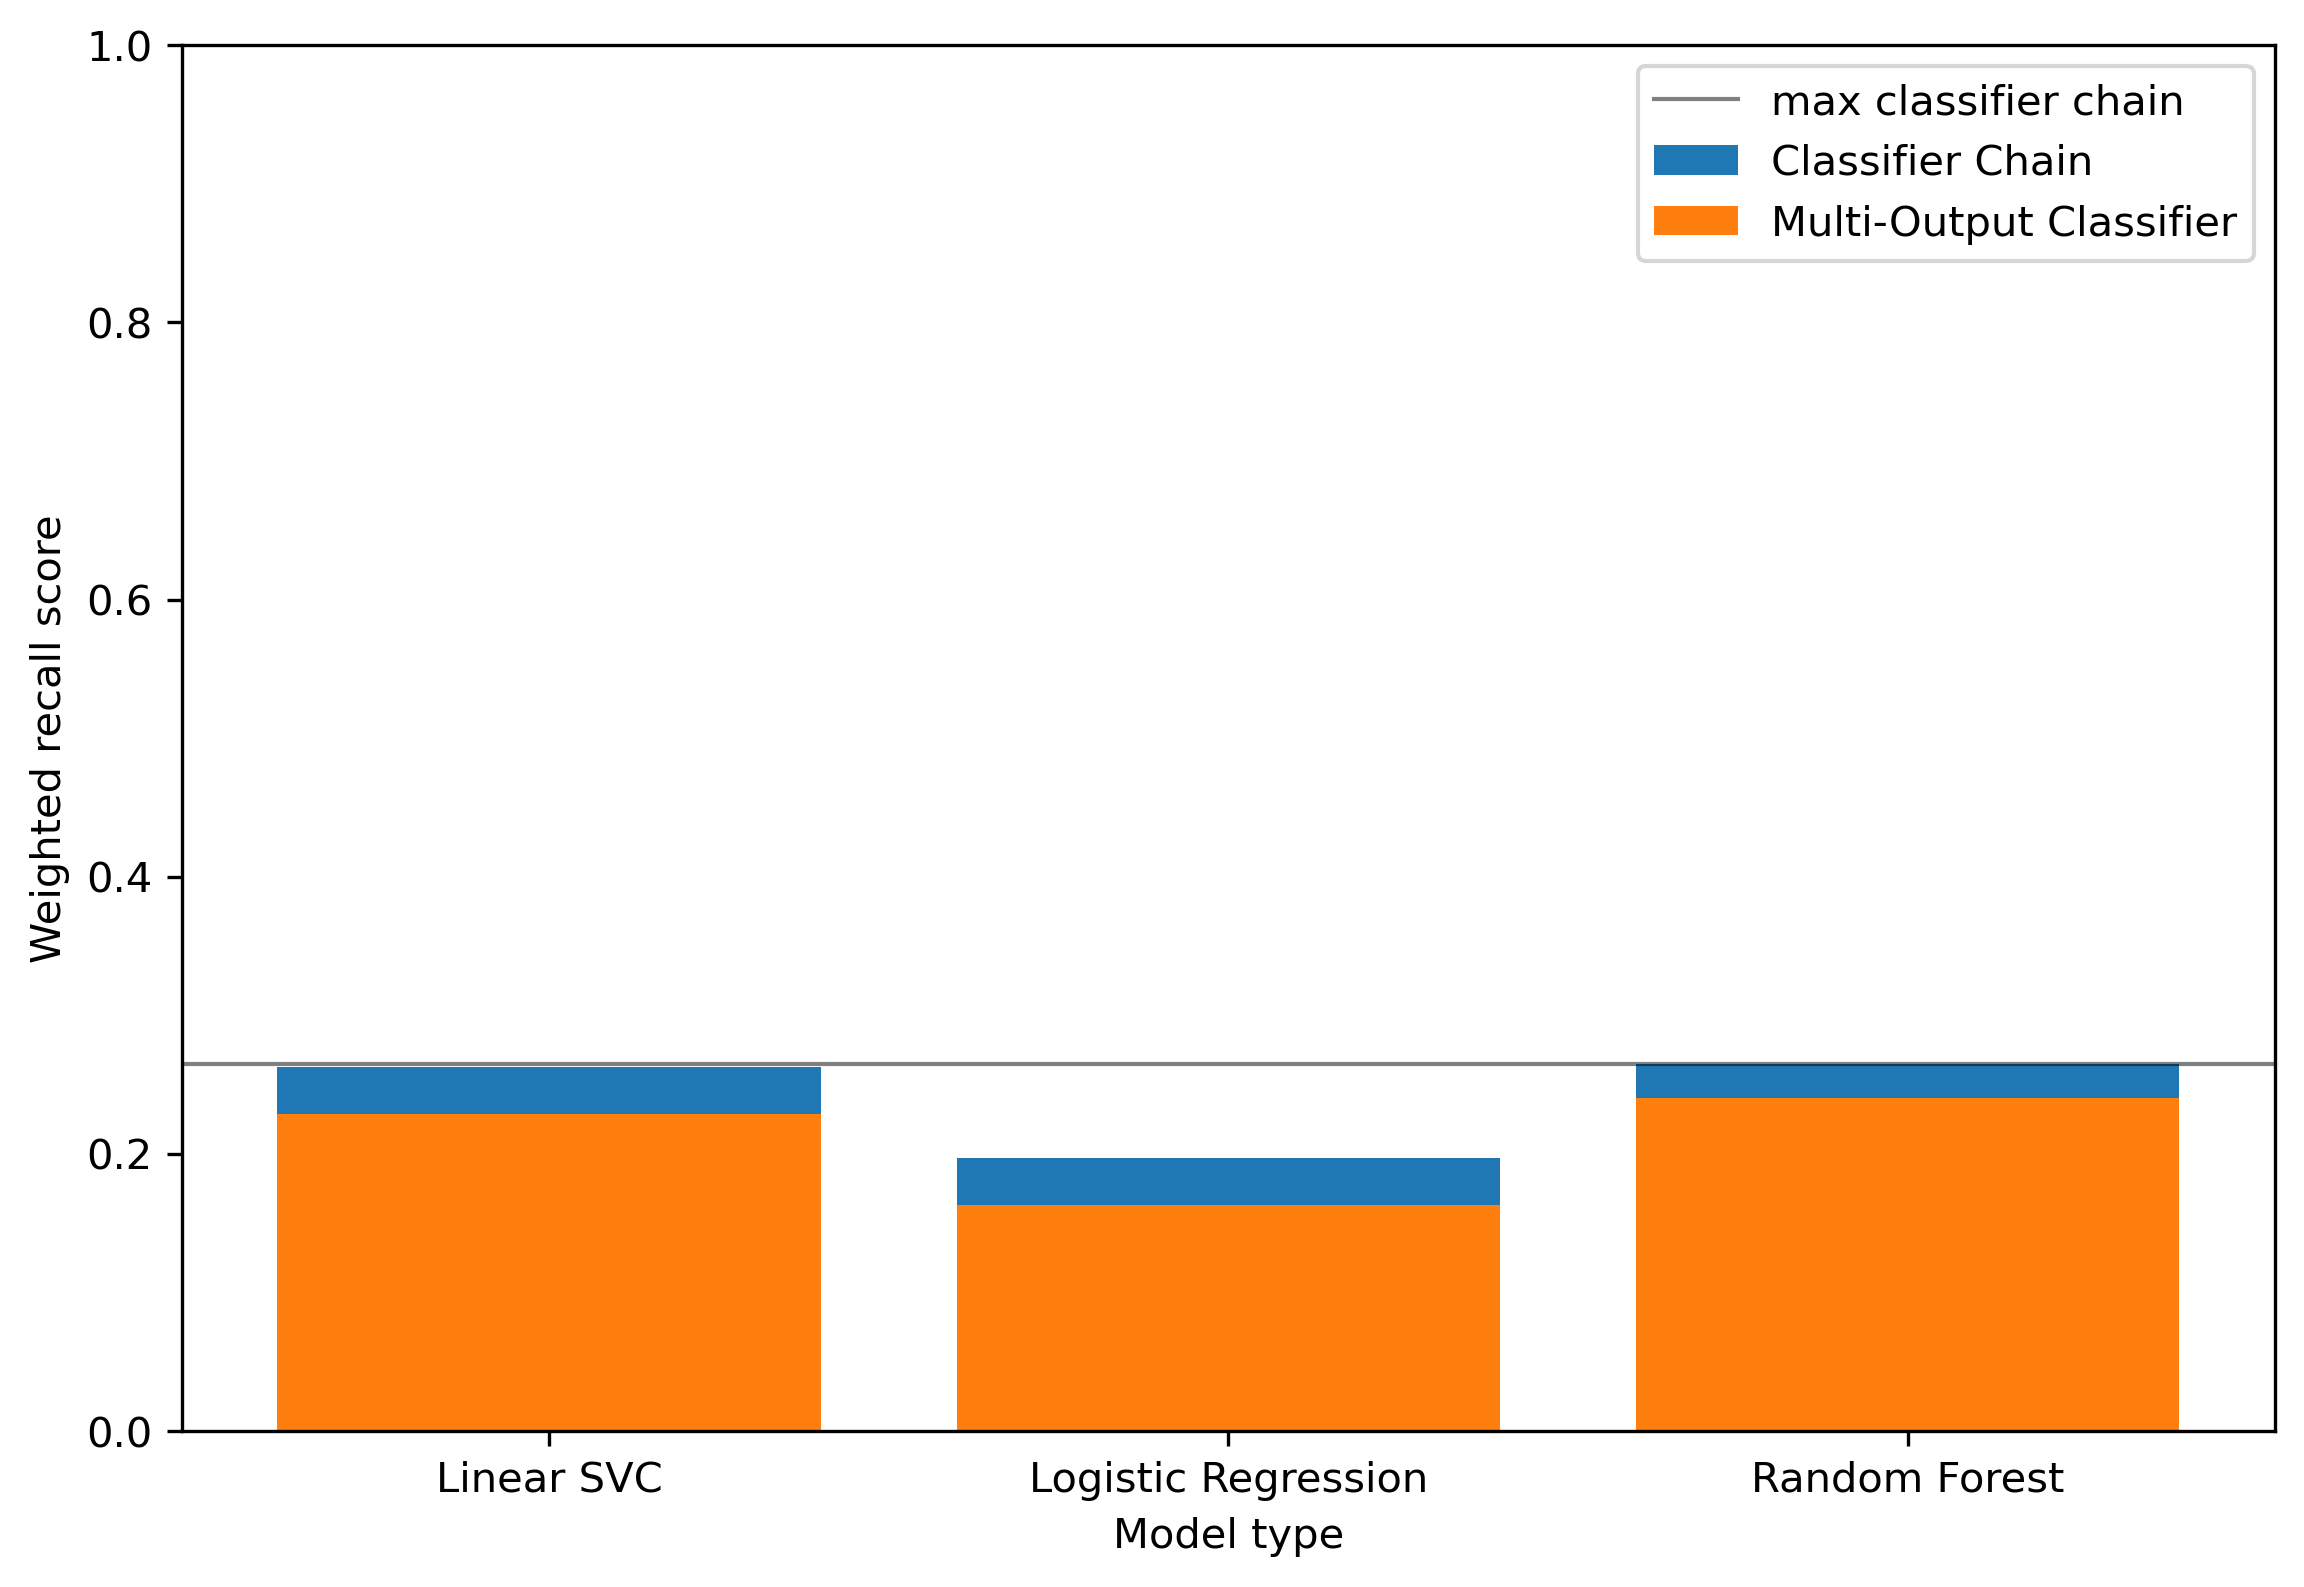

In [55]:
fig,ax = plt.subplots(figsize=[9, 6])

ax.bar(models.keys(),results_chain,label='Classifier Chain')
ax.bar(models.keys(),results_moc,label='Multi-Output Classifier')
plt.axhline(np.max(results_chain),linewidth=1, alpha=0.5, color='k', label = 'max classifier chain')

ax.set_ylim(0,1)
ax.set_xlabel('Model type')
ax.set_ylabel('Weighted recall score')
plt.legend()
plt.show()

Vemos que el `classifierchain` da resultados consistemente mejores por lo que lo vamos a preferir al multioutput. Además vemos que Random Forest y Linear SVC tienen un puntaje parecido.

El random forest parece muy prometedor ya que se pueden entrenar muchos modelos (trees) con mucha profundidad y varios hiperparametros, pero estos demoran mucho, considerando che tenemos que entrenar 28 forests cada vez, multiplicado para todos los parametros que querramos explorar, y por todos los ordenes random que querramos probar. 

Otro problema que enfrentamos en entrenar modelos pesado es que el package `multiprocessing` no funciona en notebooks autocontenidos, como es el requwerimiento del texto, lo que nos hace avanzar más despacio.

Linear SVC da resultados parecidos en este primer test y es mucho más rápido de entrenar por lo que seguiremos con este para respetar el deadline.

#### 1.4 Model choice and training
Vamos a entrenar 100  linear SVC chains con diferentes ordenes (random_state) para ver como varian sus performance (macro recall) y elegir el mejor.

In [17]:
def chain_fitter(model,n_models):
   chains = [ClassifierChain(model, order="random", random_state=i,verbose=True) for i in range(n_models)]
   for chain in chains:
      chain.fit(X_train, Y_train)
   return chains

In [62]:
def chain_predictor_plotter(fitted_chains,title="Classifier Chain Performance Comparison"):
   Y_pred_chains = np.array([chain.predict(X_test) for chain in fitted_chains])
   chain_macro_recall = [
      recall_score(Y_test,Y_pred_chain, average='macro')
      for Y_pred_chain in Y_pred_chains
      ]

   n_models = len(fitted_chains)
   x_pos = np.arange(n_models)
   #model_names = [f"Chain {n}" for n in x_pos]

   fig, ax = plt.subplots(figsize=(7, 4))
   ax.set_title(title)
   #ax.set_xticks(x_pos)
   #ax.set_xticklabels(model_names, rotation="vertical")
   ax.set_xlabel("Chain number")
   ax.set_ylabel("Macro Recall")
   ax.set_ylim([min(chain_macro_recall) * 0.9, max(chain_macro_recall) * 1.1])
   ax.bar(x_pos, chain_macro_recall)
   plt.tight_layout()

   return Y_pred_chains,chain_macro_recall,fig


In [22]:
model =  LinearSVC()
n_models = 100
chains = chain_fitter(model,n_models)

[Chain] .................. (1 of 28) Processing order 2, total=   0.3s
[Chain] ................. (2 of 28) Processing order 22, total=   0.2s
[Chain] ................. (3 of 28) Processing order 14, total=   0.2s
[Chain] ................. (4 of 28) Processing order 17, total=   0.3s
[Chain] .................. (5 of 28) Processing order 5, total=   0.2s
[Chain] ................. (6 of 28) Processing order 11, total=   0.1s
[Chain] ................. (7 of 28) Processing order 24, total=   0.1s
[Chain] ................. (8 of 28) Processing order 13, total=   0.2s
[Chain] ................. (9 of 28) Processing order 20, total=   0.2s
[Chain] ................ (10 of 28) Processing order 25, total=   0.2s
[Chain] ................ (11 of 28) Processing order 16, total=   0.1s
[Chain] ................. (12 of 28) Processing order 1, total=   0.3s
[Chain] ................ (13 of 28) Processing order 10, total=   0.4s
[Chain] ................ (14 of 28) Processing order 27, total=   0.5s
[Chain

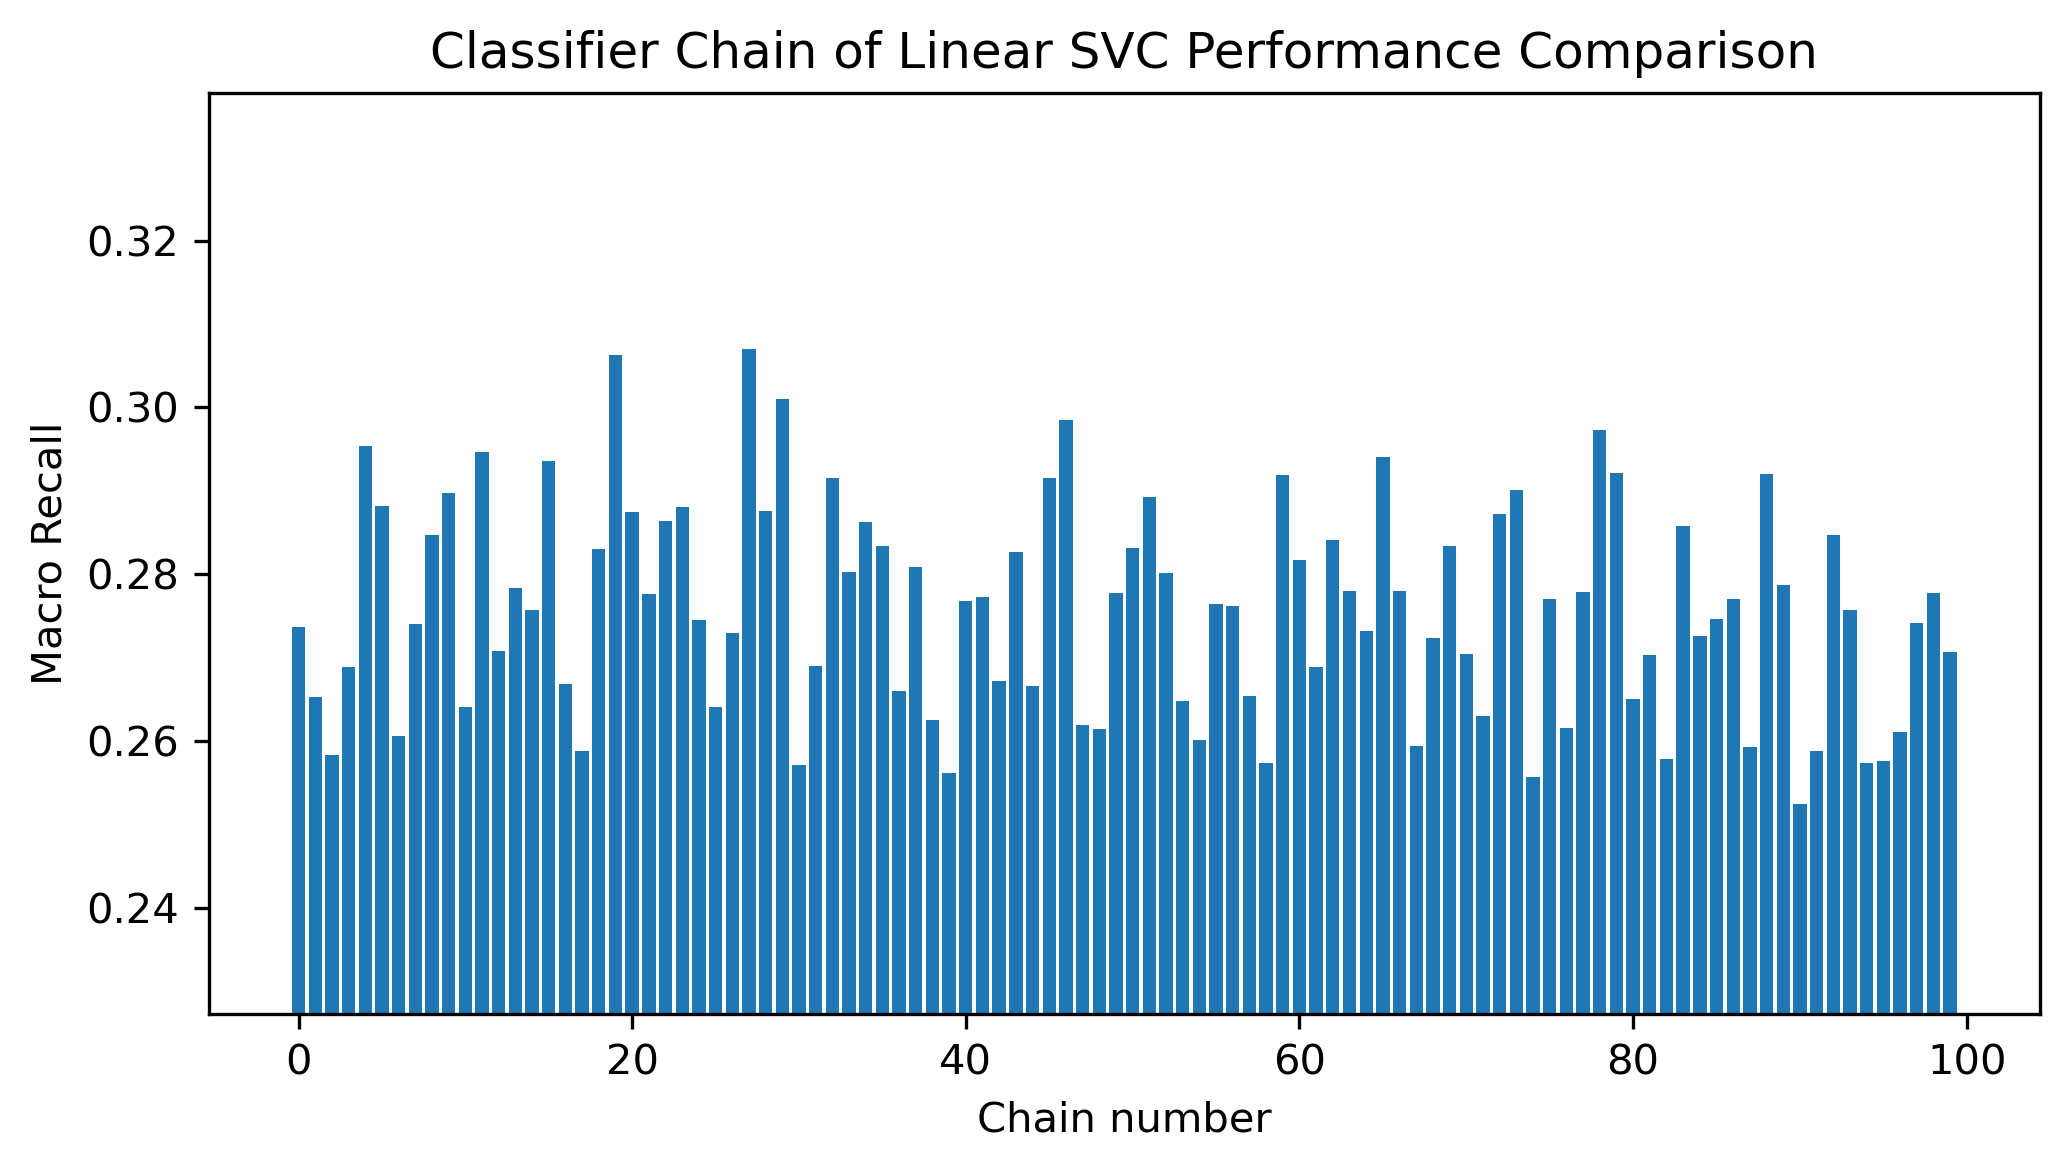

In [63]:
Y_pred_chains,chain_macro_recall,fig = chain_predictor_plotter(chains,title="Classifier Chain of Linear SVC Performance Comparison")
plt.show()

In [36]:
i = np.argmax(chain_macro_recall)
chain_macro_recall[i]

0.3070290803724787

In [37]:
best_chain = chains[i]
best_Y_pred = Y_pred_chains[i]

ClassifierChain(base_estimator=LinearSVC(), order='random', random_state=27,
                verbose=True)

Vemos que no hay mucho cambio entre las chains en el puntaje. El random:state = 27 alcanzá un macro recall de 0.31, lo que es bastante bajo, pero vamos a seguir con este modelo.

También vamos a investigar el hiperparamétro de regularización `C` si puede mejorar los resultados de este modelo. El valor de default de `C=1`, que es el que hemos usado en la iteración anterior.

In [100]:
param_grid = {'base_estimator__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}
scoring = {"recall_macro": "recall_macro", "f1_macro": 'f1_macro'}
increase_maxiter={'base_estimator__max_iter':4000}
best_chain.set_params(**increase_maxiter)
search = GridSearchCV(best_chain, param_grid, cv=3, scoring=scoring, verbose=1, n_jobs=-1,refit='recall_macro')
search.fit(X_train,Y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits
[Chain] ................. (1 of 28) Processing order 23, total=   0.1s
[Chain] ................. (1 of 28) Processing order 23, total=   0.1s
[Chain] ................. (1 of 28) Processing order 23, total=   0.1s
[Chain] ................. (1 of 28) Processing order 23, total=   0.1s
[Chain] .................. (2 of 28) Processing order 9, total=   0.1s
[Chain] .................. (2 of 28) Processing order 9, total=   0.1s
[Chain] .................. (2 of 28) Processing order 9, total=   0.1s
[Chain] .................. (2 of 28) Processing order 9, total=   0.1s
[Chain] ................. (3 of 28) Processing order 12, total=   0.1s
[Chain] ................. (3 of 28) Processing order 12, total=   0.1s
[Chain] ................. (3 of 28) Processing order 12, total=   0.1s
[Chain] ................. (3 of 28) Processing order 12, total=   0.1s
[Chain] ................. (4 of 28) Processing order 27, total=   0.2s
[Chain] ........

/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.4s
[Chain] ................ (15 of 28) Processing order 20, total=   2.6s
[Chain] ................. (6 of 28) Processing order 25, total=   2.1s
[Chain] ................. (7 of 28) Processing order 21, total=   1.3s
[Chain] ................ (16 of 28) Processing order 18, total=   3.8s
[Chain] ................ (17 of 28) Processing order 14, total=   1.5s
[Chain] ................. (8 of 28) Processing order 15, total=   3.1s
[Chain] ................. (10 of 28) Processing order 0, total=   7.3s
[Chain] ................ (11 of 28) Processing order 11, total=   1.7s
[Chain] ................. (9 of 28) Processing order 22, total=   2.8s
[Chain] ................. (18 of 28) Processing order 1, total=   4.3s
[Chain] ................. (12 of 28) Processing order 3, total=   5.1s
[Chain] ................. (10 of 28) Processing order 0, total=   6.4s
[Chain] ................ (19 of 28) Processing order 10, total=   5.4s
[Chain

/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  44.9s
[Chain] .................. (2 of 28) Processing order 9, total=   6.6s
[Chain] ................ (19 of 28) Processing order 10, total=   6.0s
[Chain] ................. (18 of 28) Processing order 1, total=   3.7s
[Chain] ................. (3 of 28) Processing order 12, total=   0.6s
[Chain] ................. (20 of 28) Processing order 2, total=   2.3s
[Chain] ................ (21 of 28) Processing order 17, total=   3.6s
[Chain] ................ (19 of 28) Processing order 10, total=   6.0s
[Chain] ................ (22 of 28) Processing order 13, total=   5.0s
[Chain] ................. (20 of 28) Processing order 2, total=   5.2s
[Chain] ................. (23 of 28) Processing order 5, total=   5.6s
[Chain] ................ (21 of 28) Processing order 17, total=   5.5s
[Chain] ................ (24 of 28) Processing order 16, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  20.2s
[Chain] ................ (25 of 28) Processing order 26, total=   3.5s
[Chain] ................ (22 of 28) Processing order 13, total=   4.0s
[Chain] ................. (26 of 28) Processing order 8, total=   1.9s
[Chain] ................ (27 of 28) Processing order 24, total=   2.2s
[Chain] ................. (23 of 28) Processing order 5, total=   4.1s
[Chain] ................ (24 of 28) Processing order 16, total=   0.8s
[Chain] ................ (28 of 28) Processing order 19, total=   1.2s
[Chain] ................ (25 of 28) Processing order 26, total=   2.4s
[Chain] ................. (1 of 28) Processing order 23, total=   0.6s
[Chain] ................. (6 of 28) Processing order 25, total=   8.9s
[Chain] ................. (26 of 28) Processing order 8, total=   1.2s
[Chain] ................ (27 of 28) Processing order 24, total=   1.1s
[Chain] ................ (28 of 28) Processing order 19, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   2.4s
[Chain] ................. (1 of 28) Processing order 23, total=   1.0s
[Chain] .................. (2 of 28) Processing order 9, total=   5.3s
[Chain] ................. (3 of 28) Processing order 12, total=   2.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   7.5s
[Chain] ................. (4 of 28) Processing order 27, total=  39.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   9.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   2.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   8.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  18.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  14.6s
[Chain] ................. (6 of 28) Processing order 25, total=   5.3s
[Chain] ................ (11 of 28) Processing order 11, total=   3.4s
[Chain] ................. (7 of 28) Processing order 21, total=   2.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   8.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  13.5s
[Chain] ................. (4 of 28) Processing order 27, total=  43.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   6.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   9.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  46.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  14.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  15.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   5.9s
[Chain] ................ (11 of 28) Processing order 11, total=   2.3s
[Chain] ................. (7 of 28) Processing order 21, total=   1.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  15.1s
[Chain] ................. (8 of 28) Processing order 15, total=   3.4s
[Chain] .................. (5 of 28) Processing order 7, total=  13.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=   8.7s
[Chain] ................. (9 of 28) Processing order 22, total=   3.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   2.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   6.6s
[Chain] ................ (17 of 28) Processing order 14, total=   2.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   5.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  10.0s
[Chain] ................ (11 of 28) Processing order 11, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=   9.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=   8.5s
[Chain] ................ (19 of 28) Processing order 10, total=   7.6s
[Chain] ................ (15 of 28) Processing order 20, total=   6.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  10.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   5.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   3.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   9.1s
[Chain] ................ (16 of 28) Processing order 18, total=   7.1s
[Chain] ................ (17 of 28) Processing order 14, total=   2.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   7.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  12.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   8.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   4.3s
[Chain] ................ (24 of 28) Processing order 16, total=   0.3s
[Chain] ................. (14 of 28) Processing order 4, total=  13.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   2.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   6.2s
[Chain] ................. (26 of 28) Processing order 8, total=   1.2s
[Chain] ................ (15 of 28) Processing order 20, total=   3.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   6.7s
[Chain] ................ (27 of 28) Processing order 24, total=   0.9s
[Chain] ................ (28 of 28) Processing order 19, total=   0.4s
[Chain] ................. (1 of 28) Processing order 23, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   3.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   4.3s
[Chain] ................ (17 of 28) Processing order 14, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  11.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   8.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.6s
[Chain] ................ (21 of 28) Processing order 17, total=   8.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=  11.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   5.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   8.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   5.6s
[Chain] ................ (24 of 28) Processing order 16, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   7.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   2.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   1.6s
[Chain] ................. (26 of 28) Processing order 8, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   3.3s
[Chain] ................ (27 of 28) Processing order 24, total=   1.0s
[Chain] ................ (28 of 28) Processing order 19, total=   0.5s
[Chain] ................. (1 of 28) Processing order 23, total=   1.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   6.9s
[Chain] ................ (21 of 28) Processing order 17, total=   5.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   7.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   4.3s
[Chain] ................ (24 of 28) Processing order 16, total=   0.2s
[Chain] ................ (19 of 28) Processing order 10, total=   9.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   3.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  34.1s
[Chain] ................. (20 of 28) Processing order 2, total=   4.5s
[Chain] ................. (26 of 28) Processing order 8, total=   1.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   2.9s
[Chain] ................ (28 of 28) Processing order 19, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   5.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   3.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   6.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  11.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   8.8s
[Chain] ................ (24 of 28) Processing order 16, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=  11.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   3.2s
[Chain] ................ (28 of 28) Processing order 19, total=   0.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   0.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=  10.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  47.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   6.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   7.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  13.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  14.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   4.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   2.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   1.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  49.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   5.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  10.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   6.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  12.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   6.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   6.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  37.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  10.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   3.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   2.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  13.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   6.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  11.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=   8.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   5.2s
[Chain] ................. (9 of 28) Processing order 22, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   2.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   7.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   3.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  12.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   8.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   2.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   9.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  13.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   4.6s
[Chain] ................. (12 of 28) Processing order 3, total=   8.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   6.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=   9.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   4.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   4.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   7.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   6.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   8.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  11.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  13.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   6.1s
[Chain] ................ (24 of 28) Processing order 16, total=   0.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   9.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   4.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=  11.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   9.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   0.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   7.4s
[Chain] ................ (28 of 28) Processing order 19, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   1.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   7.8s
[Chain] ................. (14 of 28) Processing order 4, total=  12.8s
[Chain] ................ (22 of 28) Processing order 13, total=   4.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   6.2s
[Chain] ................ (24 of 28) Processing order 16, total=   0.2s
[Chain] ................. (18 of 28) Processing order 1, total=  10.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   7.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   3.3s
[Chain] ................. (26 of 28) Processing order 8, total=   1.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   1.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.7s
[Chain] ................ (28 of 28) Processing order 19, total=   0.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   7.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.2s
[Chain] ................. (1 of 28) Processing order 23, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   5.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   7.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   4.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   7.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   3.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  34.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   5.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   2.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   1.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   4.8s
[Chain] ................. (1 of 28) Processing order 23, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   2.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=   9.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   3.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   2.6s
[Chain] ................ (24 of 28) Processing order 16, total=   0.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   1.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   3.1s
[Chain] ................ (27 of 28) Processing order 24, total=   0.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  30.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   0.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=   9.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  12.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   4.3s
[Chain] ................. (6 of 28) Processing order 25, total=   9.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  35.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  11.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   7.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   3.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   6.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=  15.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  19.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  49.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   6.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  21.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   5.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   9.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=  10.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.7s
[Chain] .................. (5 of 28) Processing order 7, total=  16.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   6.8s
[Chain] ................. (12 of 28) Processing order 3, total=  15.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   5.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   1.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   9.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=  10.3s
[Chain] ................. (8 of 28) Processing order 15, total=   5.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  15.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   8.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=  13.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  18.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   6.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  11.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  14.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   7.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   4.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   8.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   6.4s
[Chain] ................. (13 of 28) Processing order 6, total=  14.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=  12.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   4.2s
[Chain] ................ (24 of 28) Processing order 16, total=   0.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  12.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   2.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   2.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   8.1s
[Chain] ................ (28 of 28) Processing order 19, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  11.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   7.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   6.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   8.4s
[Chain] .................. (2 of 28) Processing order 9, total=   6.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   1.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   5.8s
[Chain] ................. (14 of 28) Processing order 4, total=  11.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   5.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   6.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=  10.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   5.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   3.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   2.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=  10.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=  11.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   1.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (1 of 28) Processing order 23, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   7.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   9.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   5.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   4.5s
[Chain] ................. (3 of 28) Processing order 12, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   2.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  41.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   3.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   4.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   0.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   2.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   3.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   1.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.9s
[Chain] .................. (5 of 28) Processing order 7, total=  12.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   0.5s
[Chain] ................. (1 of 28) Processing order 23, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   3.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   7.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   2.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (2 of 28) Processing order 9, total=   7.4s
[Chain] ................ (27 of 28) Processing order 24, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   1.2s
[Chain] ................. (7 of 28) Processing order 21, total=   3.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (3 of 28) Processing order 12, total=   2.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   7.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  39.4s
[Chain] ................. (9 of 28) Processing order 22, total=   5.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=   7.2s
[Chain] .................. (5 of 28) Processing order 7, total=   7.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   3.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   7.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  11.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (4 of 28) Processing order 27, total=  35.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   2.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] .................. (5 of 28) Processing order 7, total=   6.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (6 of 28) Processing order 25, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (7 of 28) Processing order 21, total=   2.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  12.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  13.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   2.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (8 of 28) Processing order 15, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (9 of 28) Processing order 22, total=   5.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=  11.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   8.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   1.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (10 of 28) Processing order 0, total=  10.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   5.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (11 of 28) Processing order 11, total=   1.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   6.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (12 of 28) Processing order 3, total=   8.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  10.2s
[Chain] ................ (19 of 28) Processing order 10, total=   7.2s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (20 of 28) Processing order 2, total=   3.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (13 of 28) Processing order 6, total=   4.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   4.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   3.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   4.9s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   3.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   2.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (14 of 28) Processing order 4, total=  10.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   4.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   0.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   2.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (15 of 28) Processing order 20, total=   4.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   1.6s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   0.5s
[Chain] ................. (18 of 28) Processing order 1, total=   8.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (16 of 28) Processing order 18, total=   3.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (17 of 28) Processing order 14, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   6.6s
[Chain] ................. (20 of 28) Processing order 2, total=   5.1s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (18 of 28) Processing order 1, total=   8.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   4.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (19 of 28) Processing order 10, total=   8.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   6.0s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (24 of 28) Processing order 16, total=   1.1s
[Chain] ................. (20 of 28) Processing order 2, total=   6.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   4.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   2.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (21 of 28) Processing order 17, total=   8.0s
[Chain] ................ (27 of 28) Processing order 24, total=   0.8s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.7s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (22 of 28) Processing order 13, total=   4.3s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (23 of 28) Processing order 5, total=   3.5s
[Chain] ................ (24 of 28) Processing order 16, total=   0.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (25 of 28) Processing order 26, total=   1.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................. (26 of 28) Processing order 8, total=   1.4s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (27 of 28) Processing order 24, total=   0.5s


/Users/Ros/miniconda3/envs/base3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Chain] ................ (28 of 28) Processing order 19, total=   0.2s
[Chain] ................. (1 of 28) Processing order 23, total=   0.1s
[Chain] .................. (2 of 28) Processing order 9, total=   0.2s
[Chain] ................. (3 of 28) Processing order 12, total=   0.1s
[Chain] ................. (4 of 28) Processing order 27, total=   0.4s
[Chain] .................. (5 of 28) Processing order 7, total=   0.2s
[Chain] ................. (6 of 28) Processing order 25, total=   0.4s
[Chain] ................. (7 of 28) Processing order 21, total=   0.1s
[Chain] ................. (8 of 28) Processing order 15, total=   0.2s
[Chain] ................. (9 of 28) Processing order 22, total=   0.6s
[Chain] ................. (10 of 28) Processing order 0, total=   1.2s
[Chain] ................ (11 of 28) Processing order 11, total=   0.4s
[Chain] ................. (12 of 28) Processing order 3, total=   0.7s
[Chain] ................. (13 of 28) Processing order 6, total=   0.4s
[Chain

GridSearchCV(cv=3,
             estimator=ClassifierChain(base_estimator=LinearSVC(max_iter=4000),
                                       order='random', random_state=27,
                                       verbose=True),
             n_jobs=-1,
             param_grid={'base_estimator__C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20,
                                               50, 100, 200, 500, 1000]},
             refit='recall_macro',
             scoring={'f1_macro': 'f1_macro', 'recall_macro': 'recall_macro'},
             verbose=1)

In [118]:
best_hyperparams = search.best_params_
print('Best hyerparameters:\n', best_hyperparams)
best_score = search.best_score_
print('Best score:\n',np.round(best_score,2))

Best hyerparameters:
 {'base_estimator__C': 1}
Best score:
 0.3


Vemos que el parámetro de default (C=1) es el que da mejores resultados, por lo que seguimos sin cambiar modelo. Vemos también como varía el puntaje al variar de C:

In [119]:
scores=pd.DataFrame(search.cv_results_).sort_values('rank_test_recall_macro')
scores.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       8.056764      0.415585         1.050948        0.175357   
2       7.159750      0.276447         1.524460        0.438768   
4      12.283189      0.153750         1.160923        0.260850   
5      22.566689      0.254383         1.915611        0.643453   
1       5.549605      0.469881         1.353939        0.065052   

  param_base_estimator__C                      params  \
3                       1    {'base_estimator__C': 1}   
2                     0.5  {'base_estimator__C': 0.5}   
4                       2    {'base_estimator__C': 2}   
5                       5    {'base_estimator__C': 5}   
1                     0.2  {'base_estimator__C': 0.2}   

   split0_test_recall_macro  split1_test_recall_macro  \
3                  0.313048                  0.299635   
2                  0.306924                  0.299096   
4                  0.300654                  0.293750   
5                  0.278178                  0.276008   
1                  0.281127                  0.271217   

   split2_test_recall_macro  mean_test_recall_macro  std_test_recall_macro  \
3                  0.298896                0.303860               0.006504   
2                  0.297316                0.301112               0.004173   
4                  0.294129                0.296178               0.003169   
5                  0.274645                0.276277               0.001455   
1                  0.271910                0.274751               0.004517   

   rank_test_recall_macro  split0_test_f1_macro  split1_test_f1_macro  \
3                       1              0.339193              0.324216   
2                       2              0.336933              0.329460   
4                       3              0.326569              0.319116   
5                       4              0.299560              0.298484   
1                       5              0.325883              0.317246   

   split2_test_f1_macro  mean_test_f1_macro  std_test_f1_macro  \
3              0.328507            0.330639           0.006297   
2              0.328913            0.331769           0.003658   
4              0.321248            0.322311           0.003134   
5              0.297845            0.298630           0.000708   
1              0.314967            0.319366           0.004701   

   rank_test_f1_macro  
3                   2  
2                   1  
4                   3  
5                   5  
1                   4

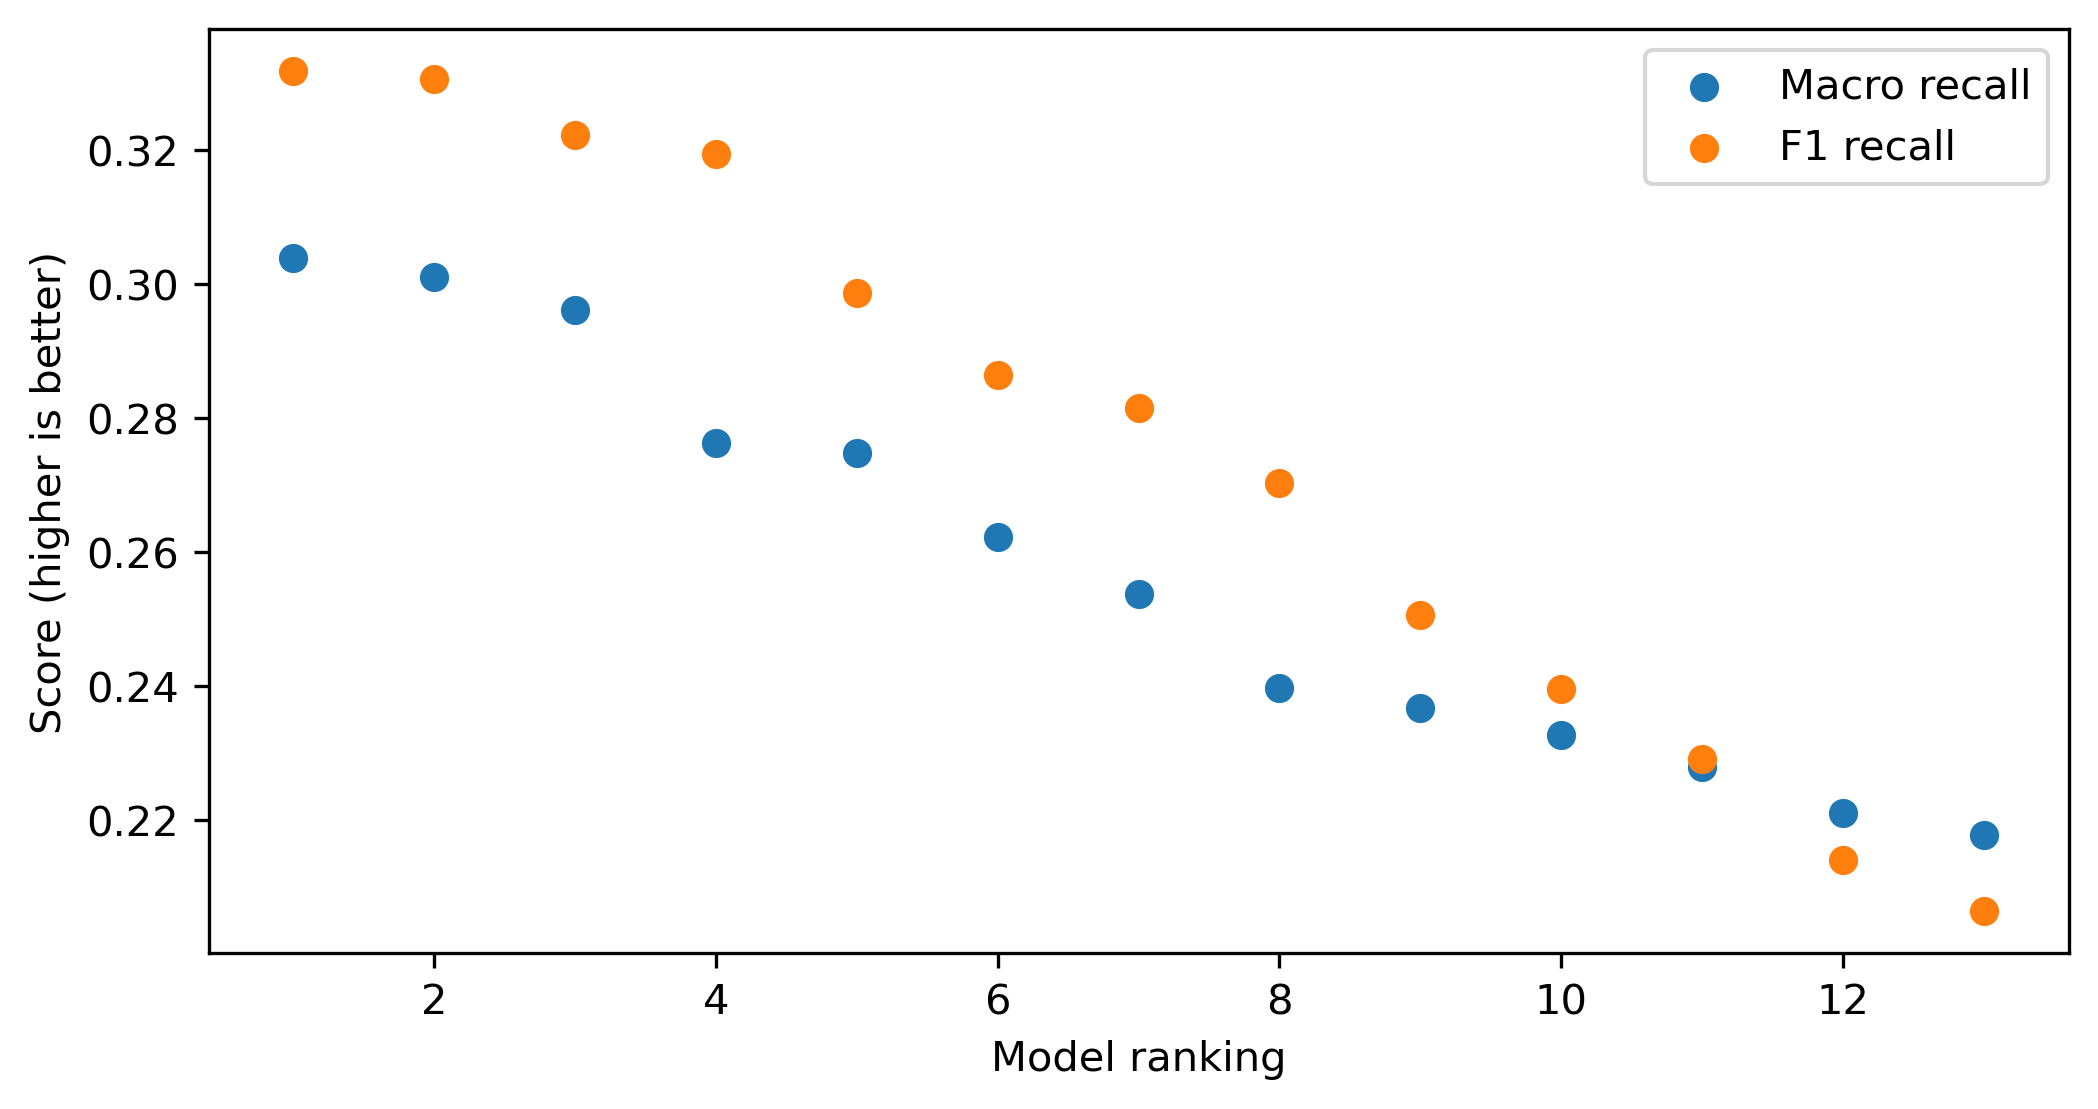

In [120]:
fig,ax=plt.subplots()
ax.scatter(scores['rank_test_recall_macro'],scores['mean_test_recall_macro'],label = 'Macro recall' )
ax.scatter(scores['rank_test_f1_macro'],scores['mean_test_f1_macro'],label = 'F1 recall' )
ax.set_xlabel('Model ranking')
ax.set_ylabel('Score (higher is better)')
plt.legend()
plt.show()

##### 1.3.3 Model evaluation

Veamos los resultados de nuestro modelo mejor sobre la muesta de validación (test): 

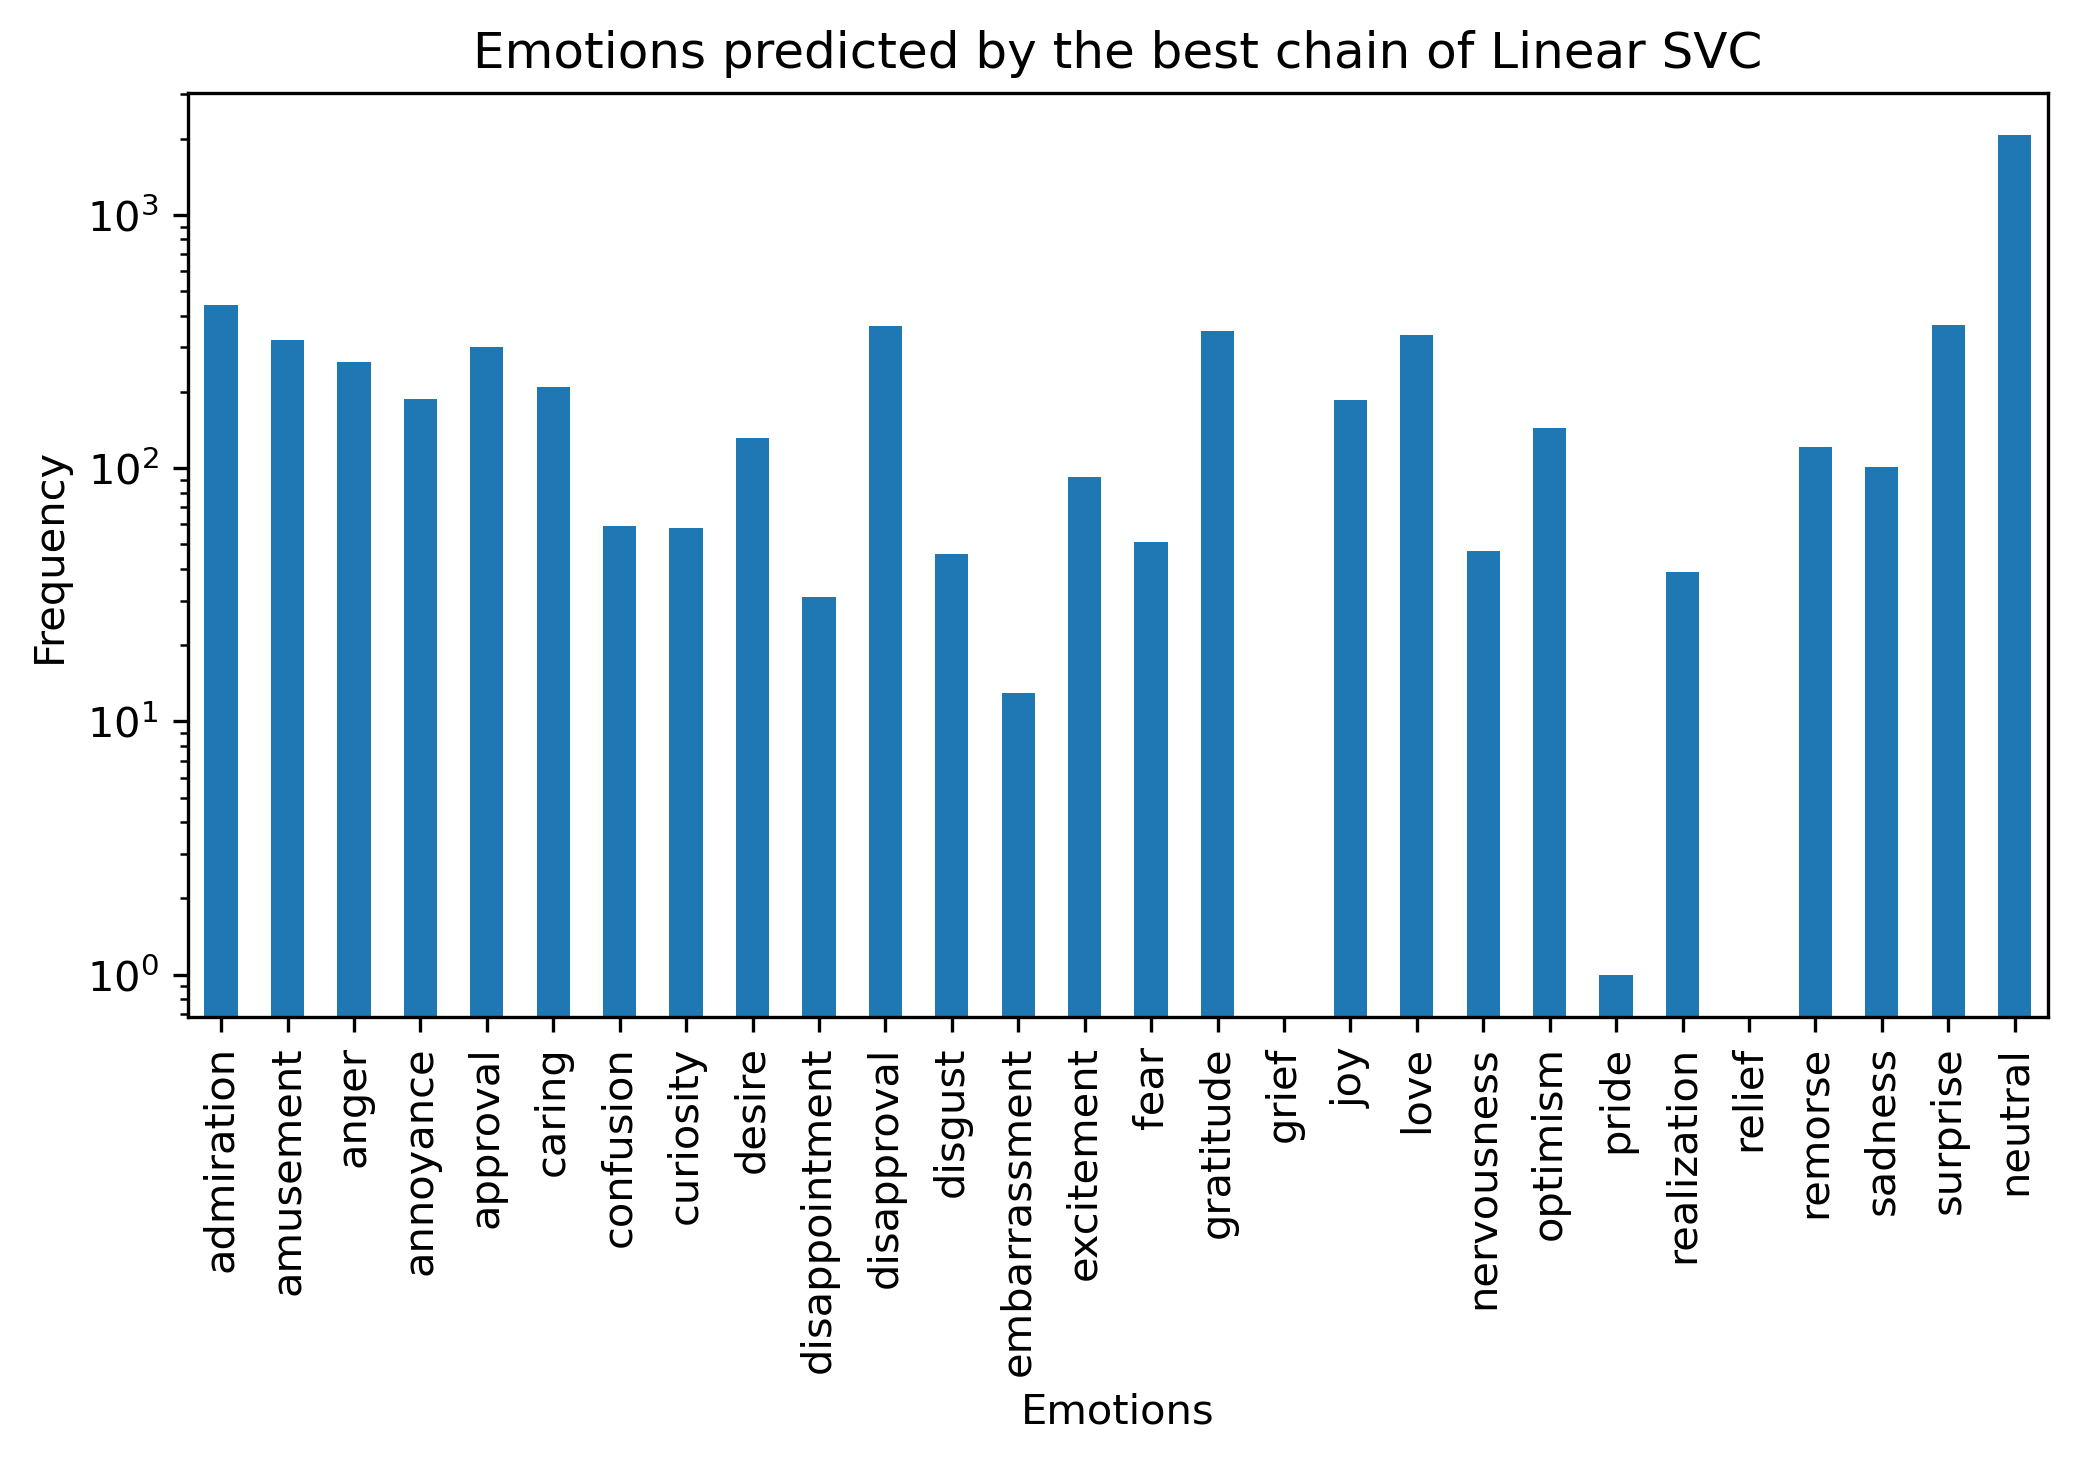

In [72]:
pred_df = pd.DataFrame(best_Y_pred, columns=original_categories)
ax = emotions_hist(pred_df,title="Emotions predicted by the best chain of Linear SVC")
plt.show()

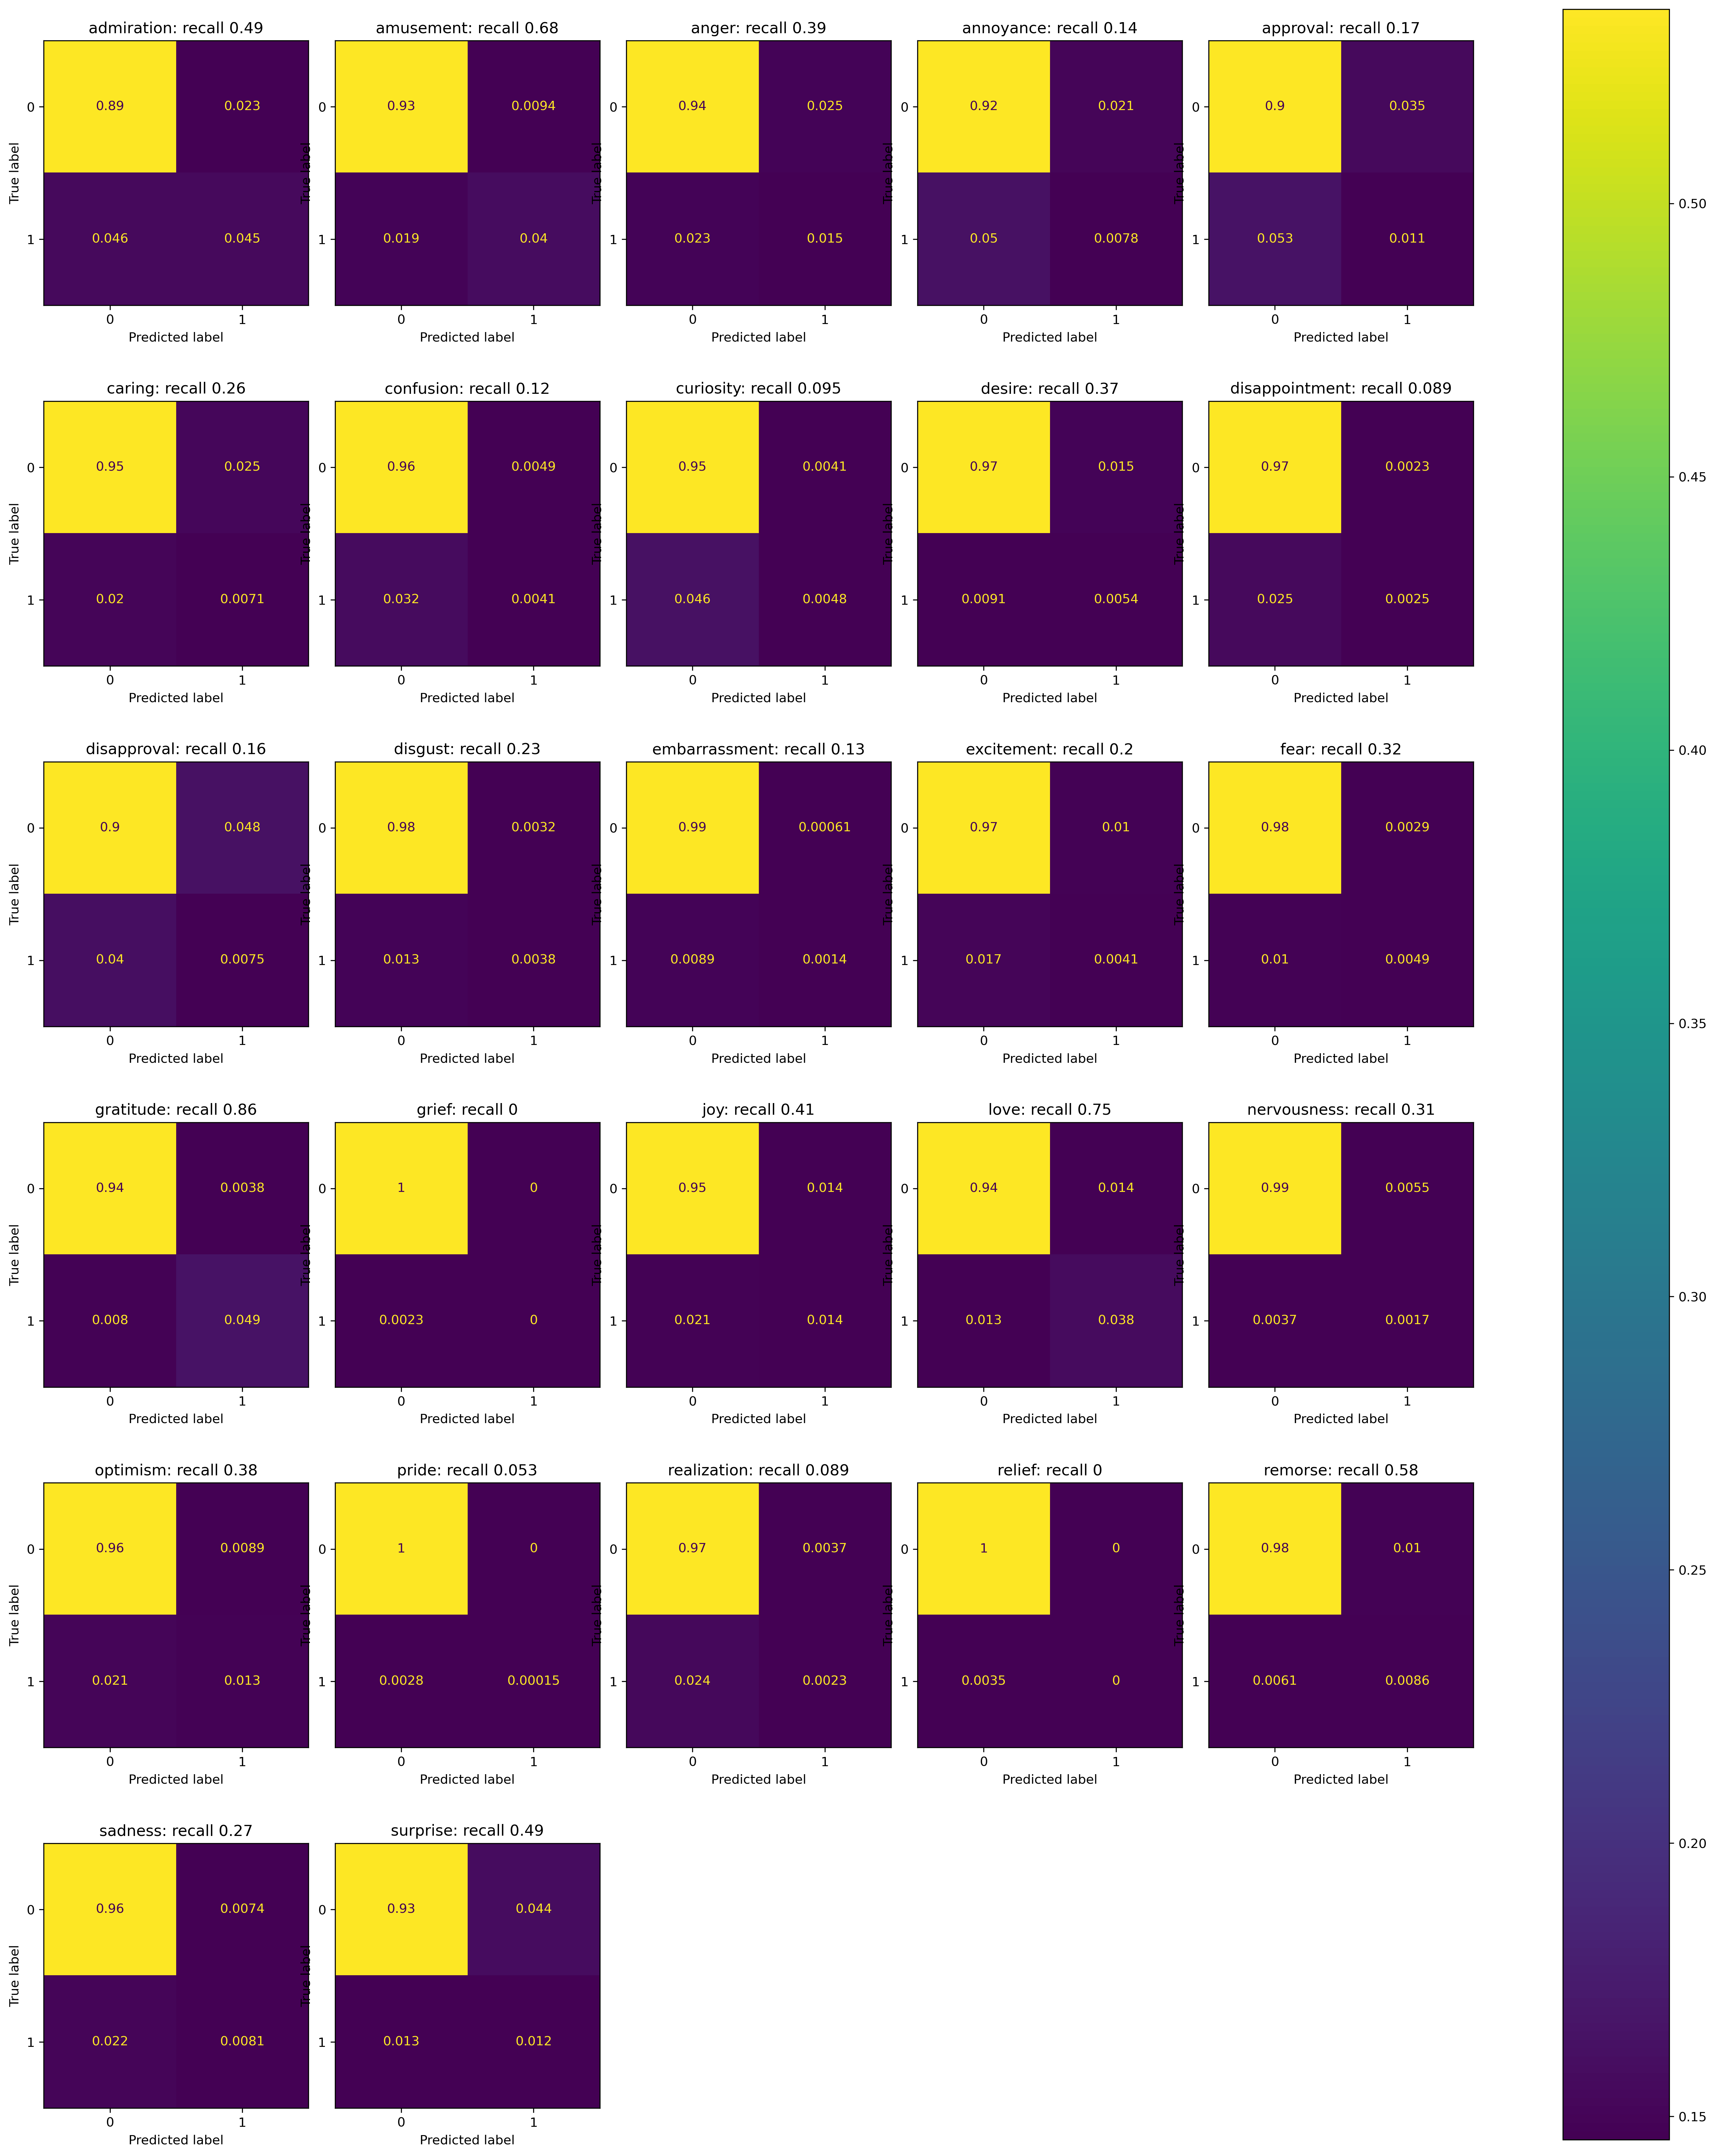

In [40]:
conf_matrix = multilabel_confusion_matrix(Y_test,best_Y_pred)
confusion_matrix_plot(conf_matrix)
plt.show()

Vemos que como se había anticipado la clase negativa es la más abundante en las confusion matrix. La proporción de las label es diferente a la verdadera de la muestra de validación.

El modelo ha alcanzado resultados decentes para algunas emociones (disappointment, curiosity, ...), pero para la mayoría no performa bien, sobretodo las que tienen baja representación.

#### 1.4 Model predictions
Predecimos las emociones para la muestra de test sin label.

In [49]:
X_testdf = vectorizer.transform(test_df.text)
Y_testdf_pred = best_chain.predict(X_testdf)
Y_testdf_pred = pd.DataFrame(Y_testdf_pred,columns = original_categories)
pred_series = inverse_dummy(Y_testdf_pred)
pred_series

0       18
1       26
2         
3       15
4       27
        ..
5422    15
5423     4
5424    27
5425    17
5426    26
Length: 5427, dtype: object

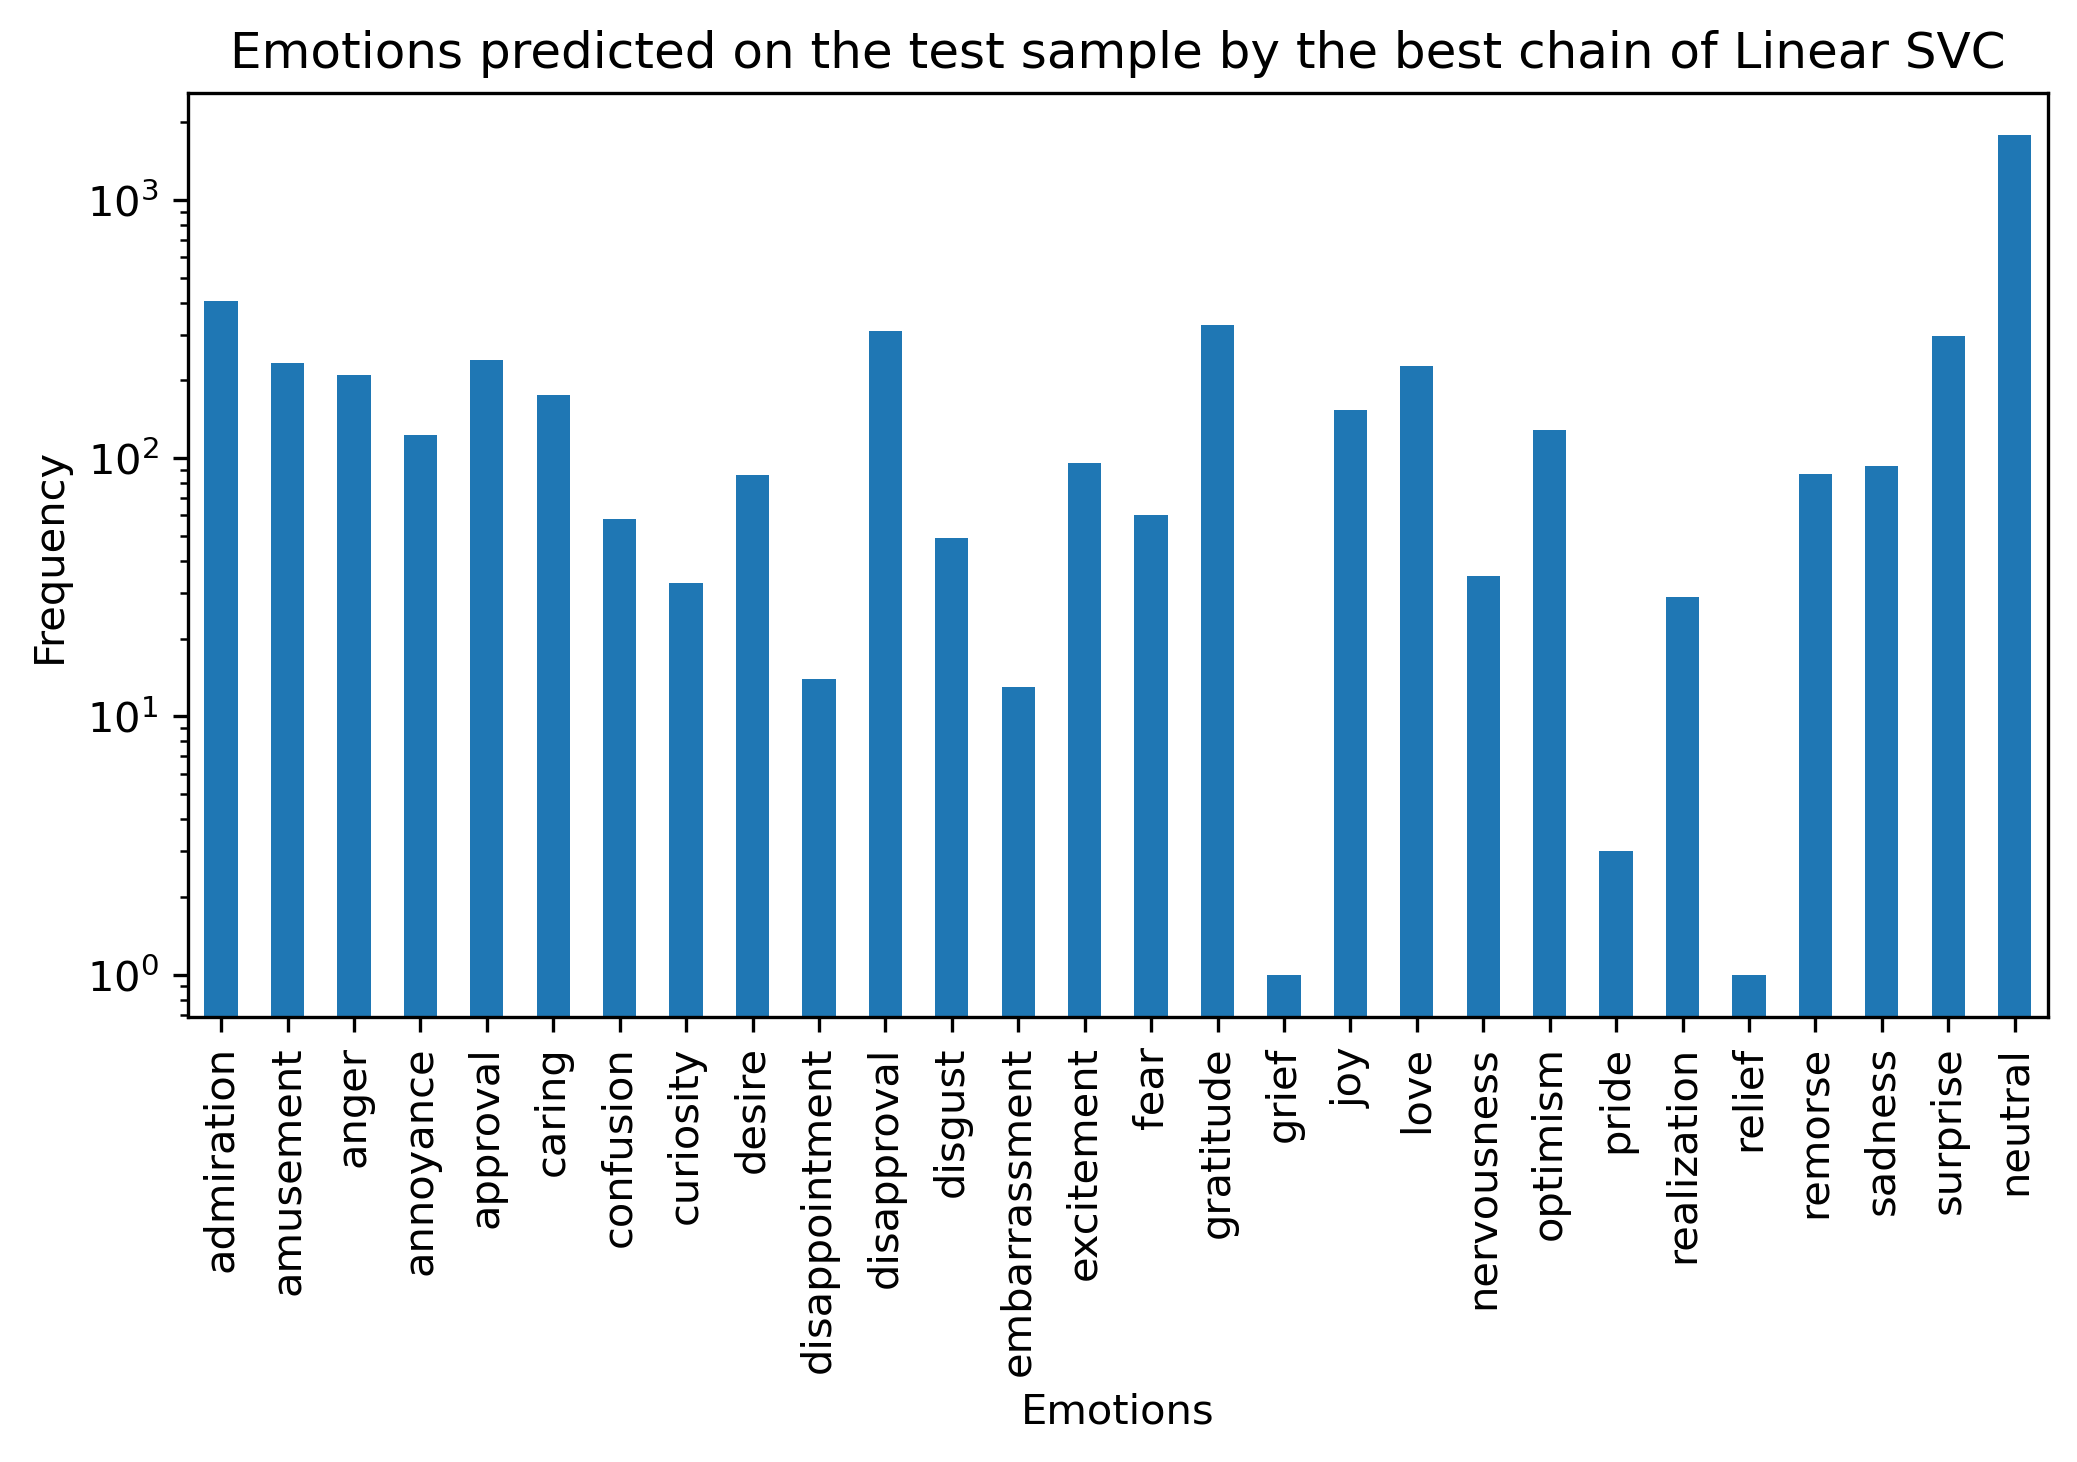

In [73]:
ax = emotions_hist(Y_testdf_pred,title="Emotions predicted on the test sample by the best chain of Linear SVC")
plt.show()

In [52]:
test_df.insert(1,'emotions',pred_series)
test_df.head()

text emotions       id
0  I’m really sorry about your situation :( Altho...       18  eecwqtt
1    It's wonderful because it's awful. At not with.       26  ed5f85d
2  Kings fan here, good luck to you guys! Will be...           een27c3
3  I didn't know that, thank you for teaching me ...       15  eelgwd1
4  They got bored from haunting earth for thousan...       27  eem5uti

In [53]:
test_df.to_csv('./data/text_test_classified.csv')

### 3. KPI
"En base a la clasificación de los comentarios, construir un indicador o KPI capaz de medir el nivel de satisfacción global, explicar significado y justificar la selección."

Para este ejercicio me he inspirado en un KPI de uso común, el **Customer Satisfaction Score (CSAT)**. En esta métrica se da la posibilidad al cliente de calificar su experiencia entre 1 (muy mala) y 5 (muy buena). En el CSAT se calcula el percentaje de respuestas entre 4 y 5, es decir de los clientes (muy) satisfechos:
$$CSAT=\frac{\text{Number of 4-5 responses}}{\text{Total number of responses}}*100.$$
Un puntaje CSAT de 75% hacia arriba es un buen indicador de éxito, pero se pueden considerar unmbrales más altos o bajos según el caso.

Para mi KPI he decidido dividir las emociones entre "positivas" y "neutras+negativas". El percentaje de entries con emociones positivas nos entrega el CSAT modificado, aplicado a nuestro caso:

$$_{m}CSAT=\frac{\text{Number of entries with positive emotions}}{\text{Total number of entries}}*100.$$

Esta definición nos permite ver de manera muy sencilla la satisfacción percibida en los textos analizados, utilizando las emociones expresadas en ellos. Cuanto más alto sea el valor de este KPI, mayor es la cantidad de clientes que expresan emociones positivas en sus comentarios.

In [74]:
print(emotions)

          emotions
0       admiration
1        amusement
2            anger
3        annoyance
4         approval
5           caring
6        confusion
7        curiosity
8           desire
9   disappointment
10     disapproval
11         disgust
12   embarrassment
13      excitement
14            fear
15       gratitude
16           grief
17             joy
18            love
19     nervousness
20        optimism
21           pride
22     realization
23          relief
24         remorse
25         sadness
26        surprise
27         neutral


Dividamos las emociones en las categorias:

In [75]:
positive_emotions = ['admiration','amusement','approval','caring','excitement','gratitude','joy','love','optimism','pride','relief']
neutneg_emotions = ['anger','annoyance','confusion','curiosity','desire','disappointment','disapproval','disgust','embarrassment','fear','grief','nervousness','realization','remorse','sadness','surprise','neutral']

Incluímos "curiosity" y "desire" entre las emociones neutras+negativas porque pueden tener connotación positiva o negativa.

Seleccionamos los indices de las emotiones positivas que vamos a usar para seleccionar las entries que las contienen:

In [76]:
positive_indices_int = [int(emotions.emotions[emotions.emotions == em].index.values) for em in positive_emotions]
positive_indices = [str(idx) for idx in positive_indices_int]
emotions.loc[positive_indices_int]

emotions
0   admiration
1    amusement
4     approval
5       caring
13  excitement
15   gratitude
17         joy
18        love
20    optimism
21       pride
23      relief

In [79]:
mCSAT = Y[Y.loc[:,positive_indices].sum(axis=1) >= 1].shape[0]/Y.shape[0]*100

print(f'The modified CSAT score for this problem is {mCSAT:.0f}%')

The modified CSAT score for this problem is 39%


El puntaje CSAT modificado en la entera muestra de training es del 39%. Menos de la mitad de los comentarios analizados expresan emociones positivas. Esta no es la impresión que tuvimos de la wordcloud.

## Parte 2

### 1. ¿De qué manera se puede complementar la solución? Pensar en propuestas para el cliente.
Para la vectorialización del texto en este estudio se podrían considerar Encodings.
Estos se producen en modelos de Neural Networks, pero se pueden encontrar pretrained y el encoding de nuevo texto no debería requerir mucho tiempo. Es una opción que merece ser evaluada debido a su aporte semántico.

Los `RandomForestClassifier` junto con la `ClassifierChain` se ven muy prometedores, pero requieren mucho tiempo para entrenar y para seleccionar el mejor modelo. En una segunda fase del trabajo se podría pensar de estudiar este tipo de modelo más en detalle.

También se podrían probar SVC de tipo no linear y explorar sus parámetros y cuanto se demoran estos modelos.

### 2. ¿Cómo se podría simplificar la tarea?
La tarea en consideración consiste en una clasificación bastante compleja, entre 28 categorías, a veces parecidas entre ellas, y además no excluyentes. Esto hace que la computación sea más complicada en todas sus partes, y hace más dificil la clasificación también a un humano, debido a la calidad de los comentarios.

Si el objetivo principal del problema es conseguir el KPI que mide la satisfacción global de los clientes, para este se requiere una clasificación mucho más sencilla que se reduce a tan solo dos clases, "emociones positivas" y "emociones neutras + negativas". Este tipo de tarea es mucho mas sencilla, sea para el training de modelos que para su evaluación y tendría más posibilidades de obtener 

Se podría pasar sencillamente del problema actual a la tarea simplificada utilizando las clasificaciones actuales y, por ejemplo, las categorias en las que se dividieron las emociones en el ejemplo del KPI.

### 3 ¿Cuáles pueden ser las limitaciones, riesgos, sesgos de los modelos al implementar este tipo de soluciones? 
Simplificando la tarea se podrían no ver todas las connotaciones de las emociones que pueden ser interesantes para el cliente.

Otros tipos de modelos "más avanzados" pueden requerir demasiado tiempo para entrenar. Lo mejor sería seguir con algo sencillo aunque más avanzado (SVC no lineares) y solo si necesario pasar a las random forest.

### 4 ¿Qué otras cosas hay que considerar al momento de implementar un proyecto como este?
Comentarios en reviews o en redes sociales pueden ser bastante dificiles de entender por algoritmos de machine learning. Esto se debe a distintos factores como uso de emojis, falta de estructura en las frases, errores de ortografía, uso de sarcasmo, abreviaciones, etc.

Modelos de redes neuronales pueden ser capaces de construir representaciones de frases enteras en base a su estructura y entender el sentimiento a partir de esta. Si se requiere una clasificación compleja como la que se pide en esta tarea (incluyendo un número muy alto de clases) puede ser oportuno considerar estas representaciones (encodings), ya que lo más complejo que hemos usado aquí son bi-grams.